In [52]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch.nn.functional as F
import numpy as np

# --- Setup: Load a pre-trained model and tokenizer ---
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name, attn_implementation="eager")
model.eval()
tokenizer.pad_token = tokenizer.eos_token
print("Setup Complete. Model and Tokenizer are loaded.")

Setup Complete. Model and Tokenizer are loaded.


--- Starting the hunt for subject-verb attention heads ---
Analyzing 4 sentences across 5 layers.
Look for heads that consistently highlight the subject from the verb's position.
------------------------------------------------------------

>>> Visualizing Layer 4 for sentence: 'The doctor wrote a prescription'


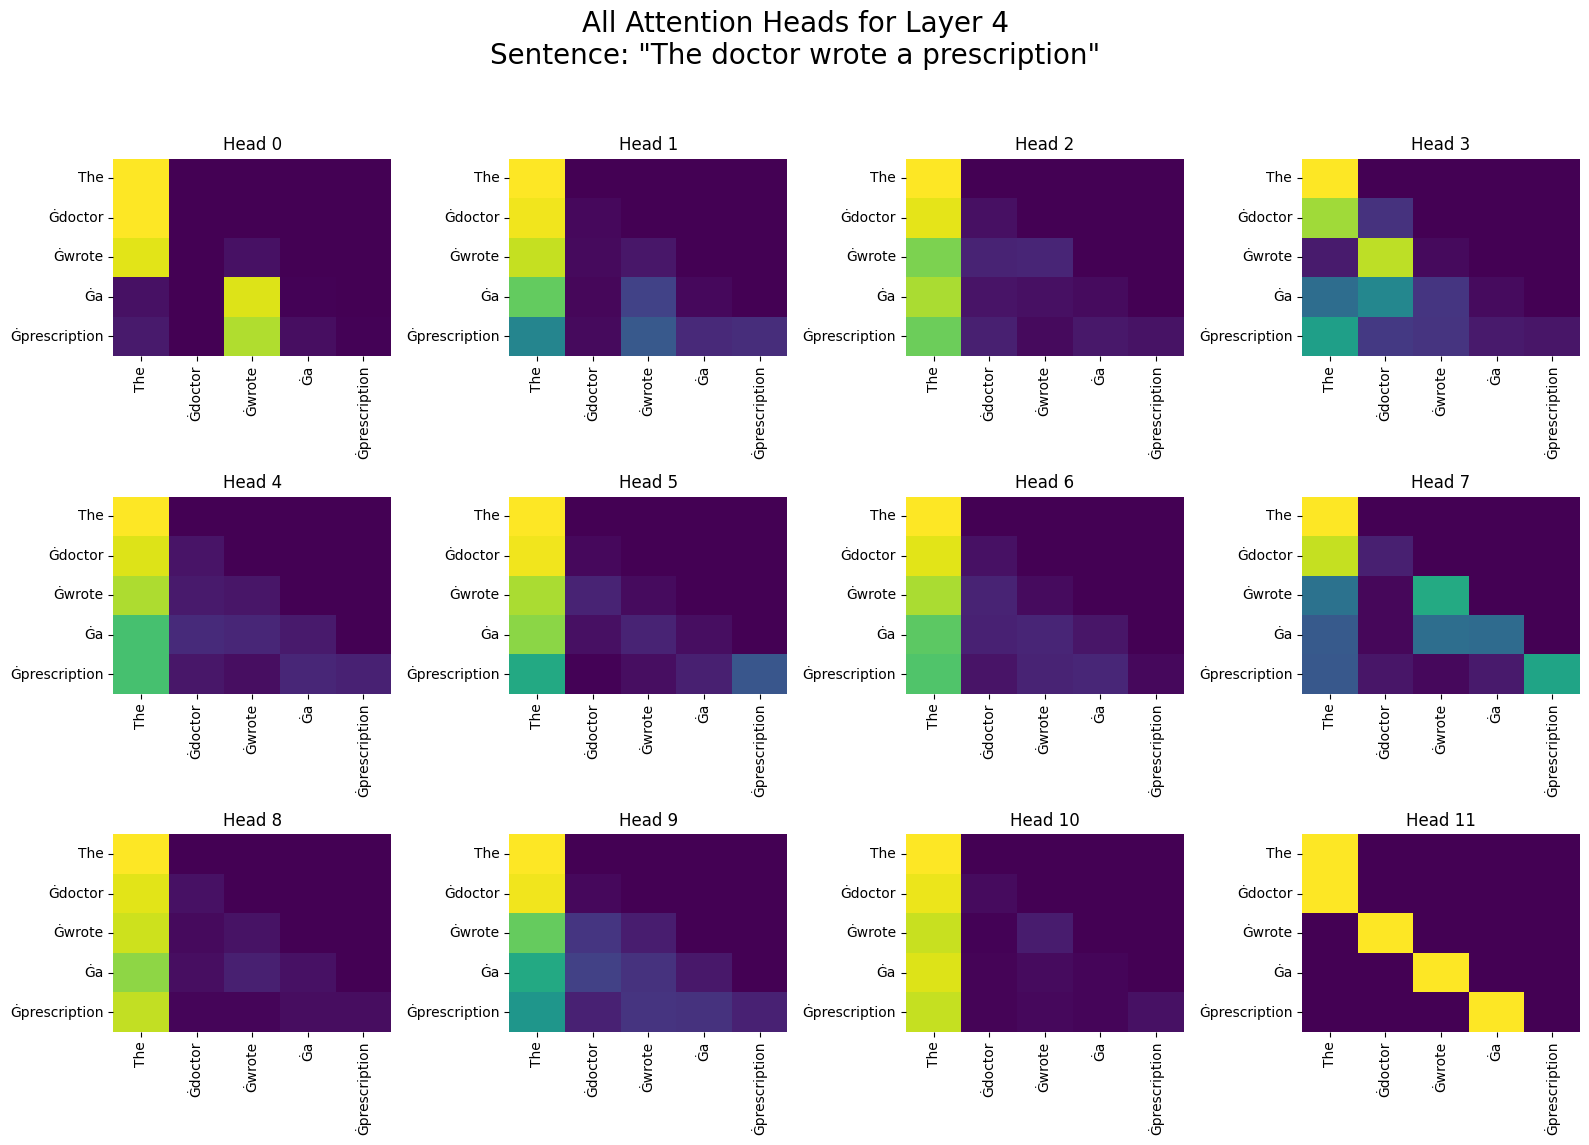


>>> Visualizing Layer 5 for sentence: 'The doctor wrote a prescription'


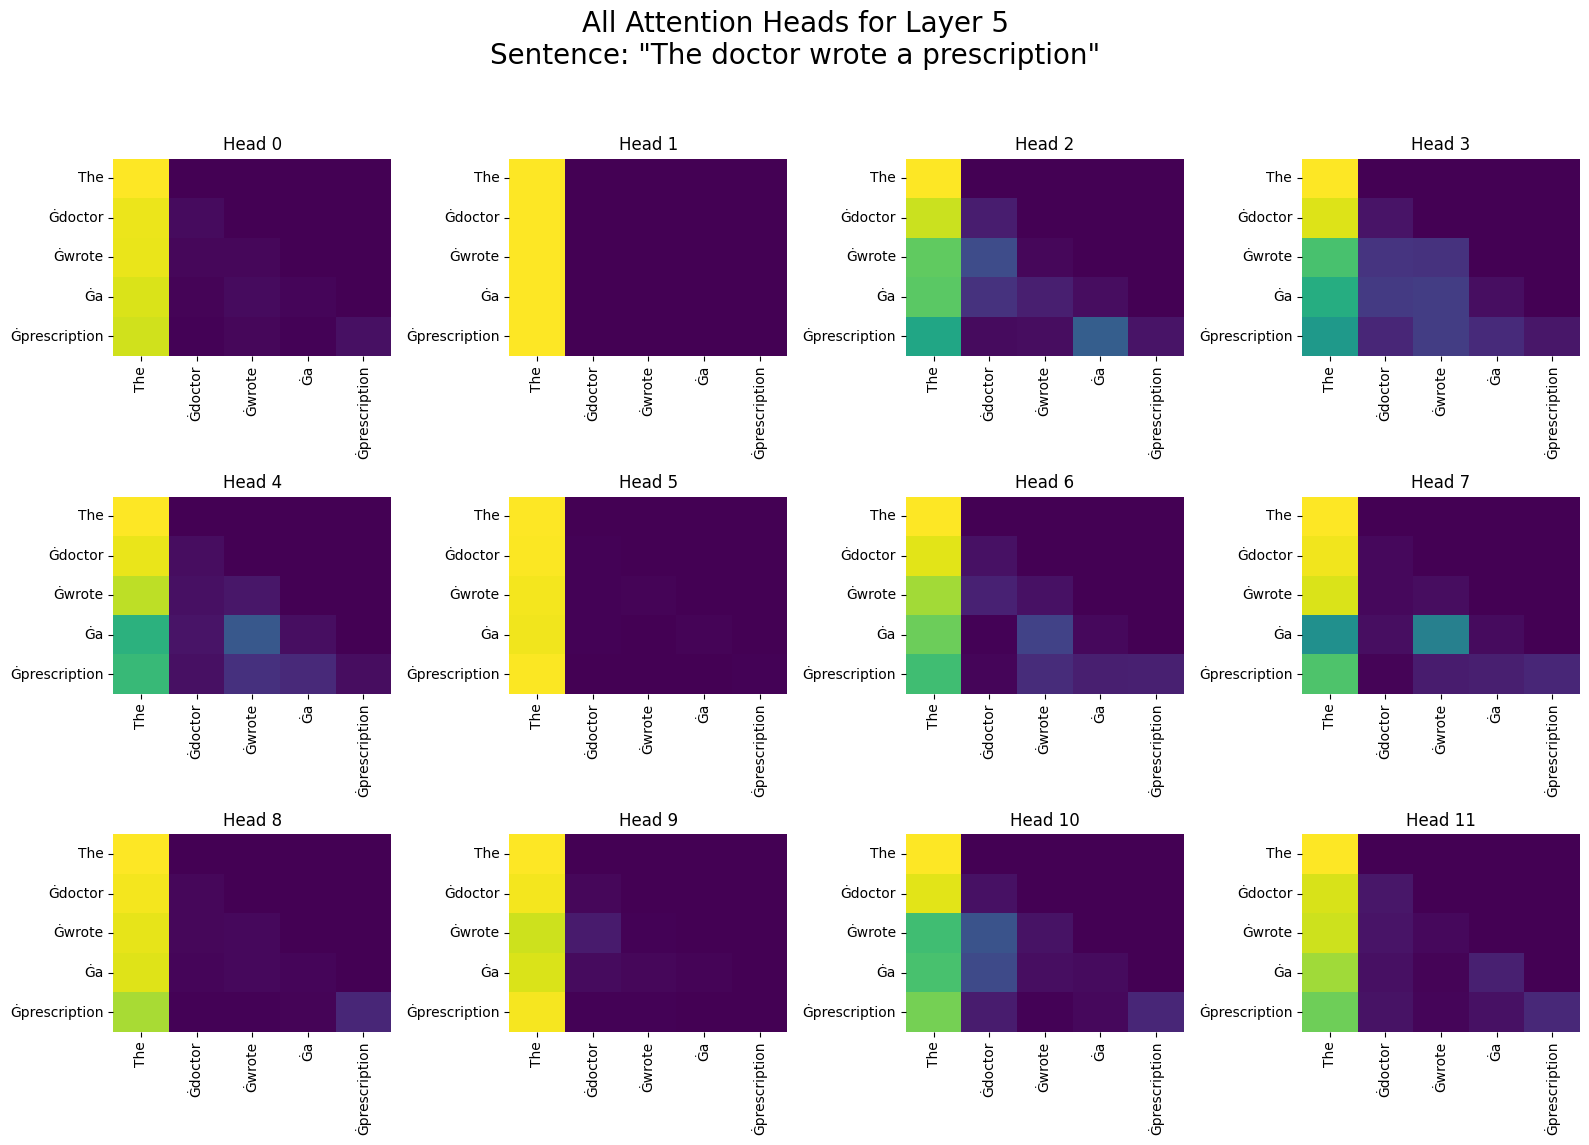


>>> Visualizing Layer 6 for sentence: 'The doctor wrote a prescription'


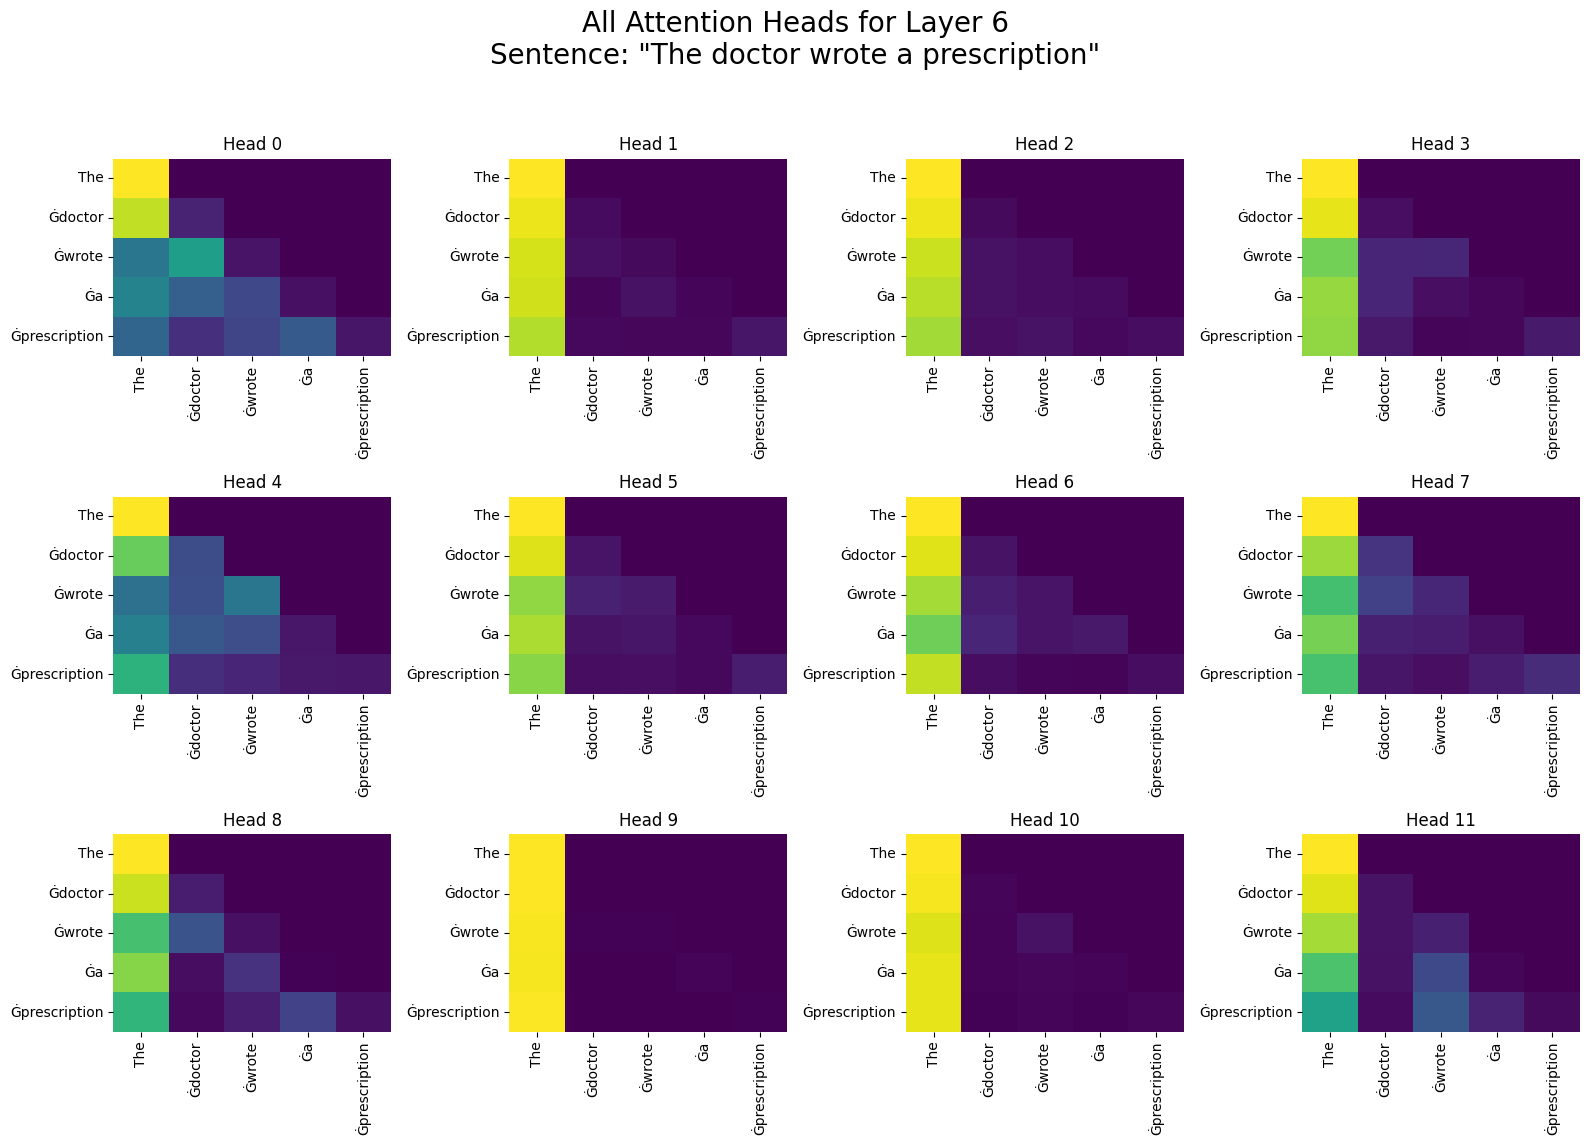


>>> Visualizing Layer 7 for sentence: 'The doctor wrote a prescription'


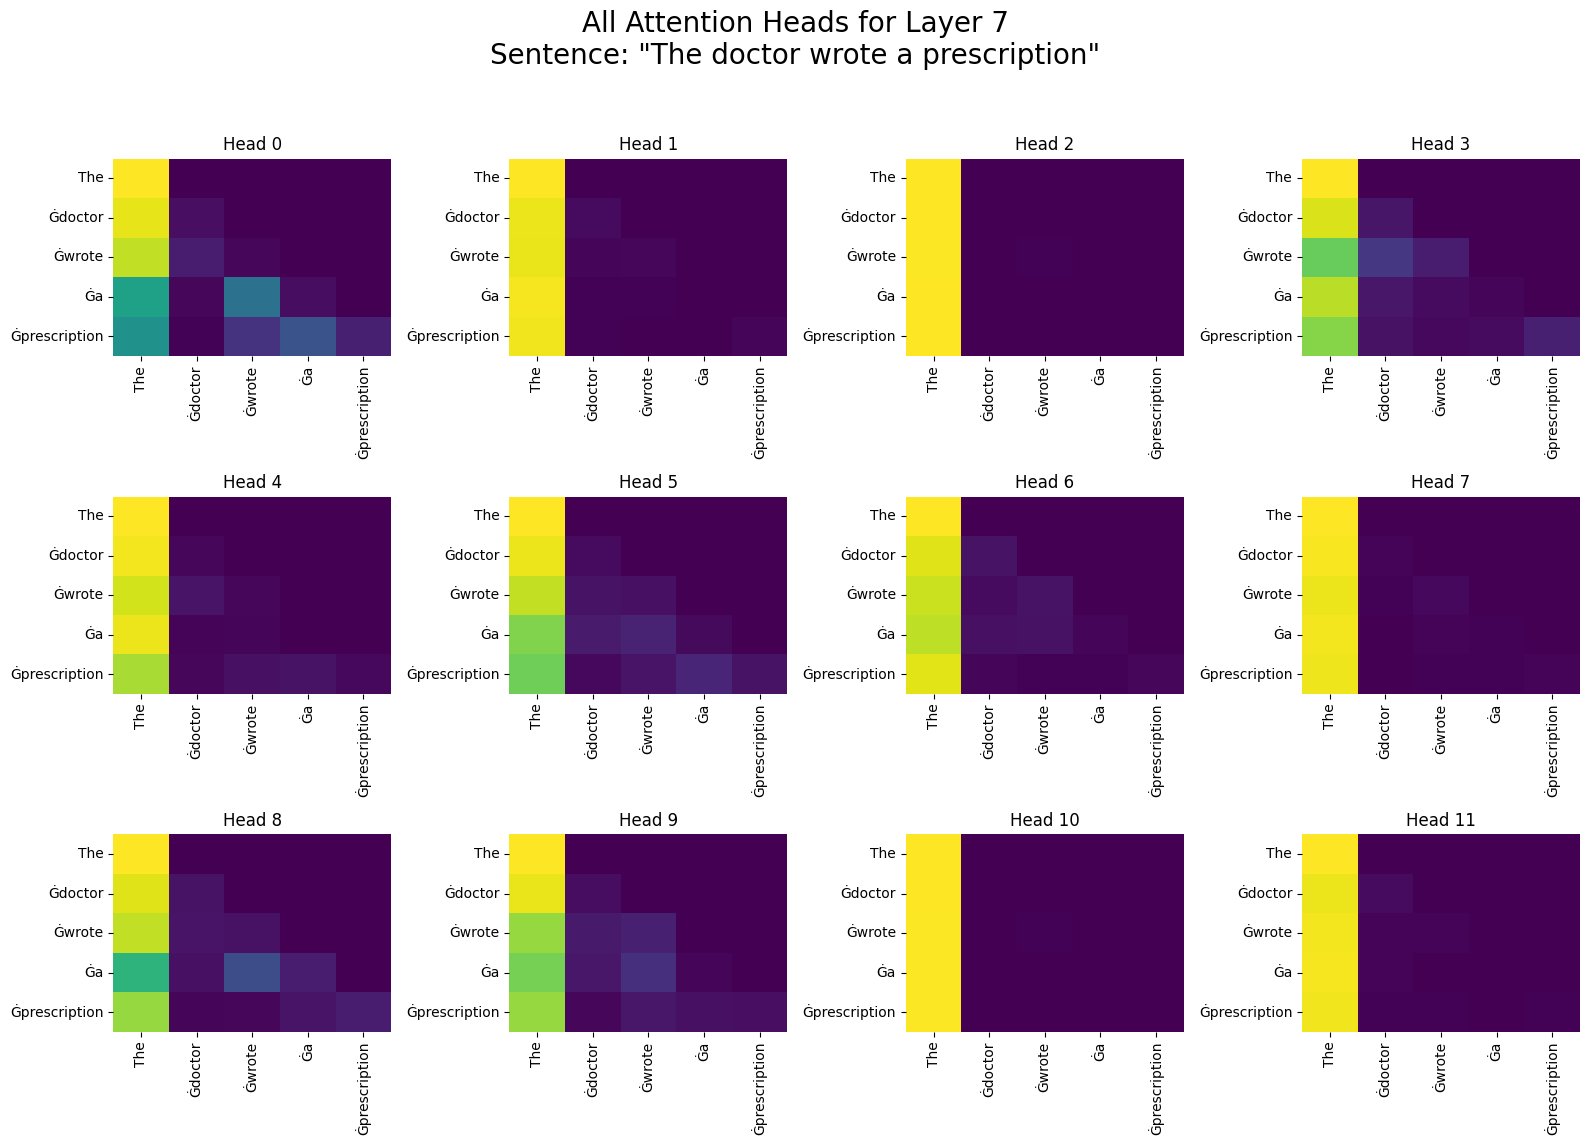


>>> Visualizing Layer 8 for sentence: 'The doctor wrote a prescription'


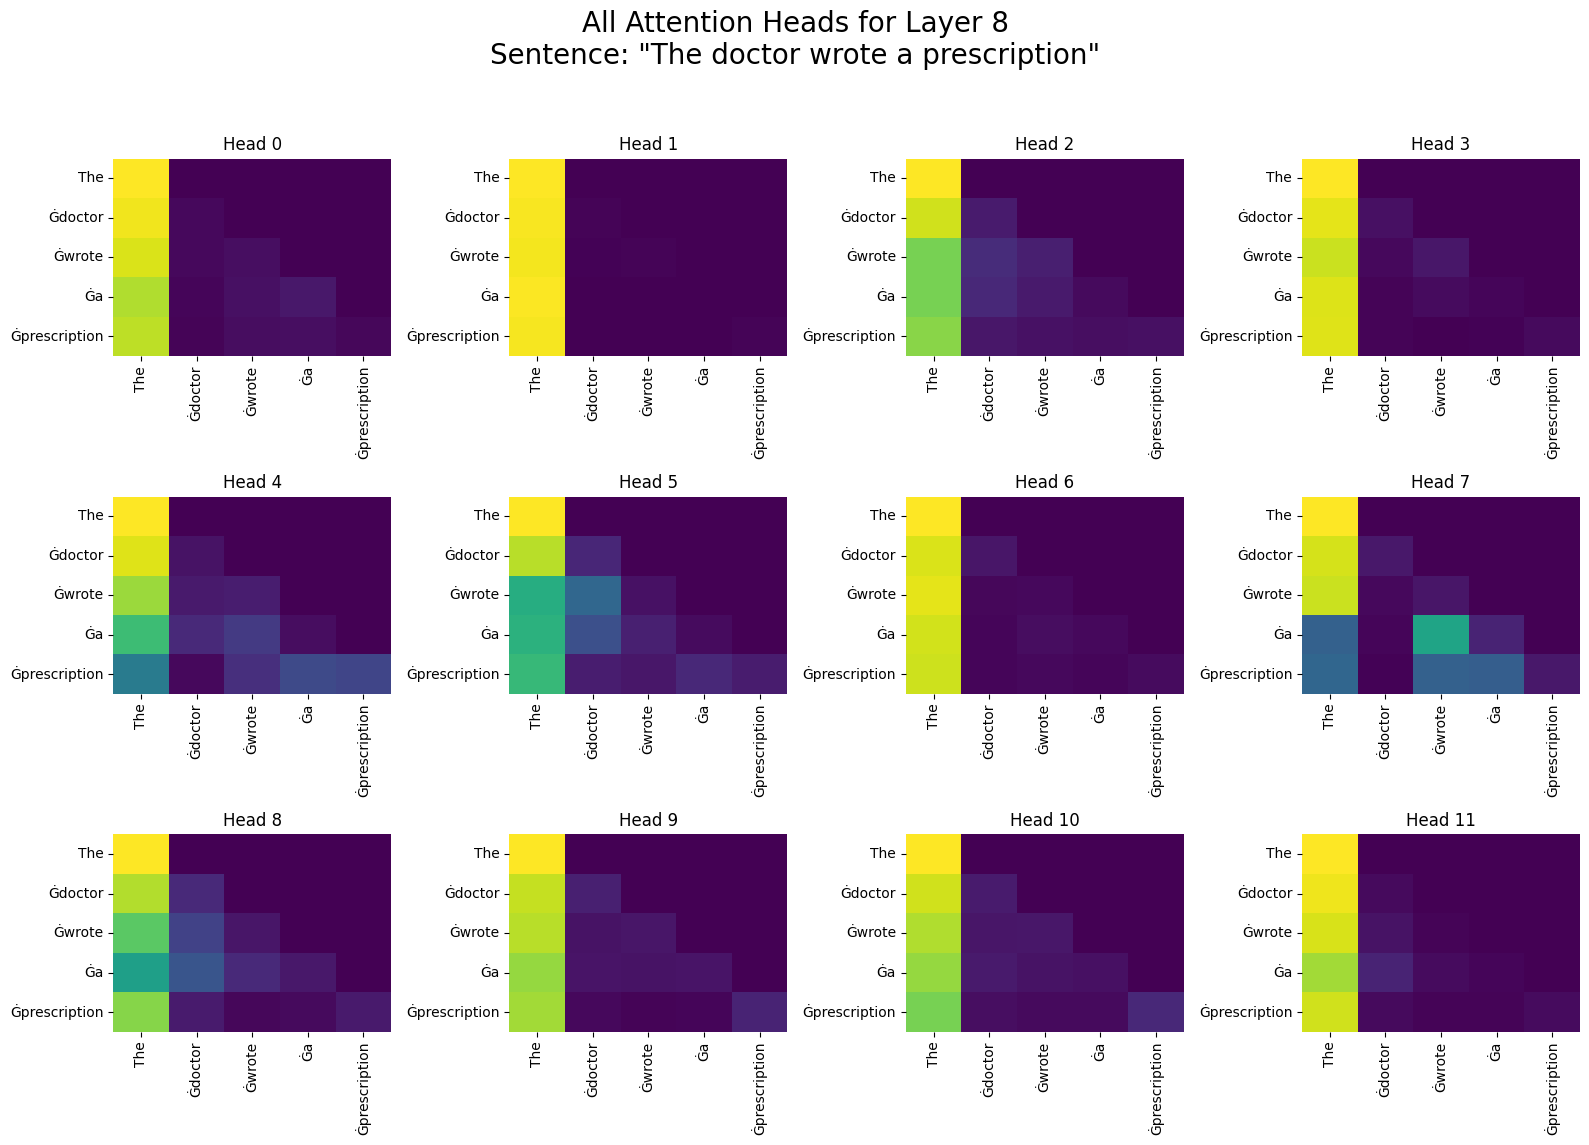


>>> Visualizing Layer 4 for sentence: 'The chef cooked the meal'


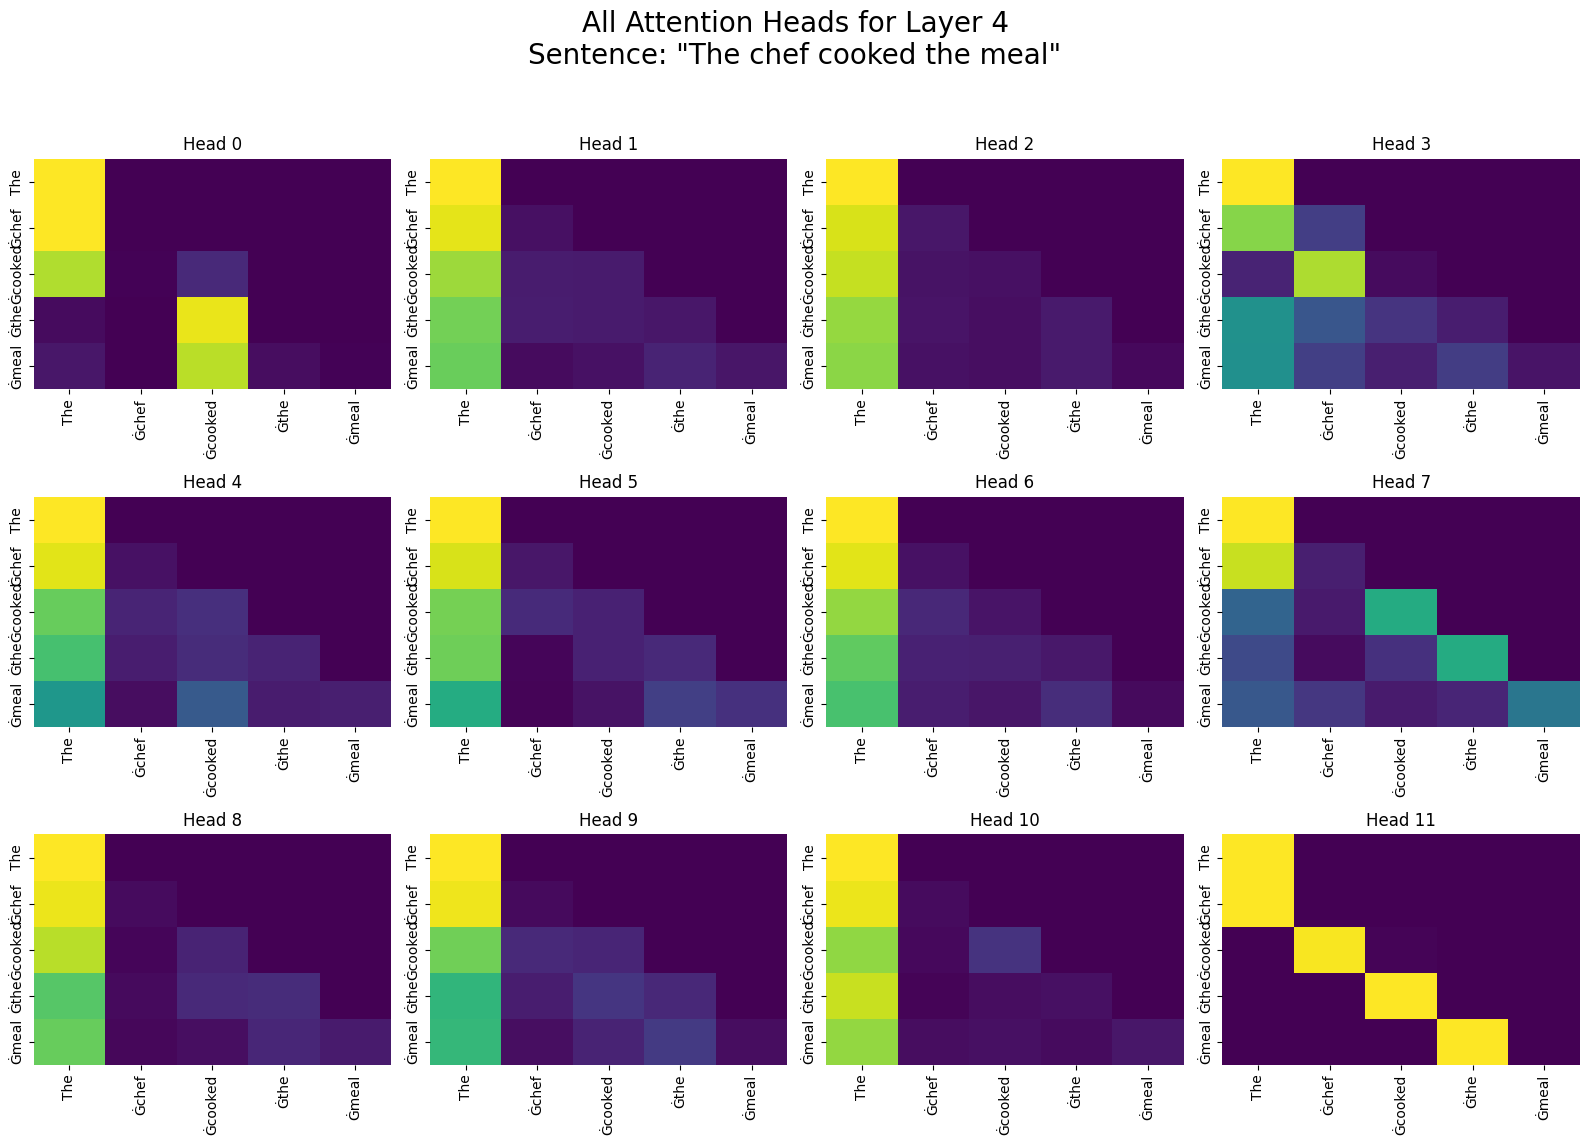


>>> Visualizing Layer 5 for sentence: 'The chef cooked the meal'


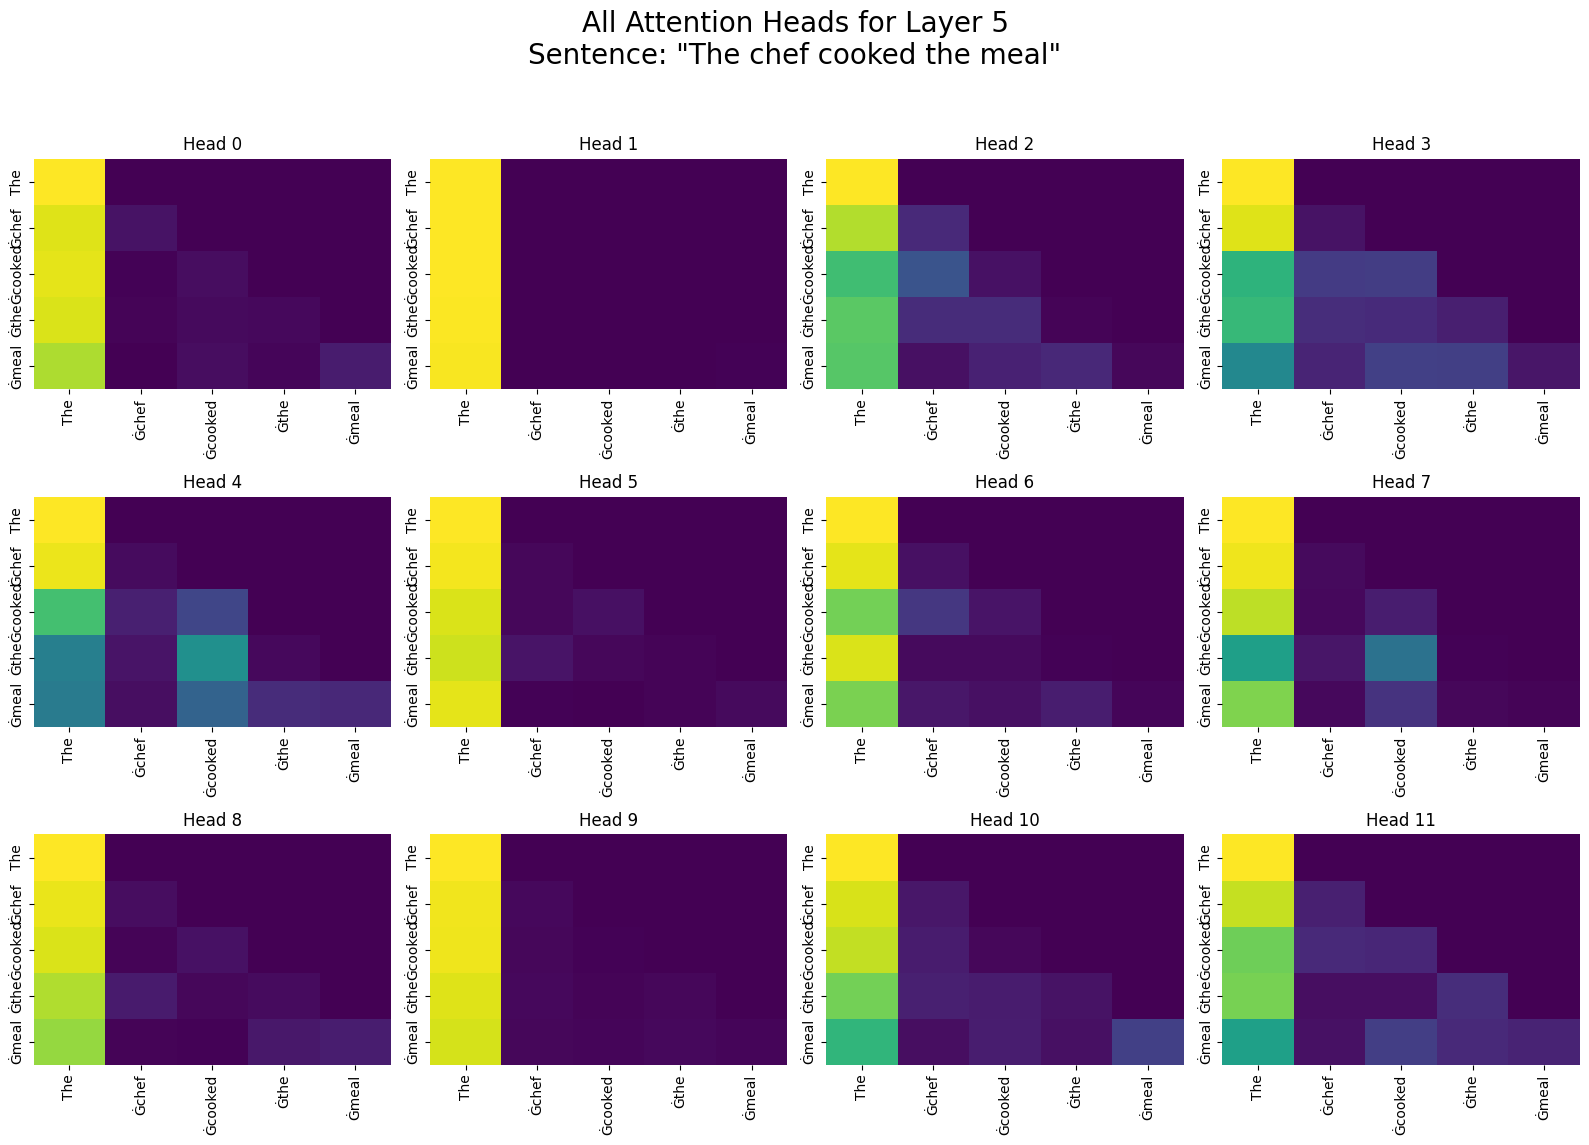


>>> Visualizing Layer 6 for sentence: 'The chef cooked the meal'


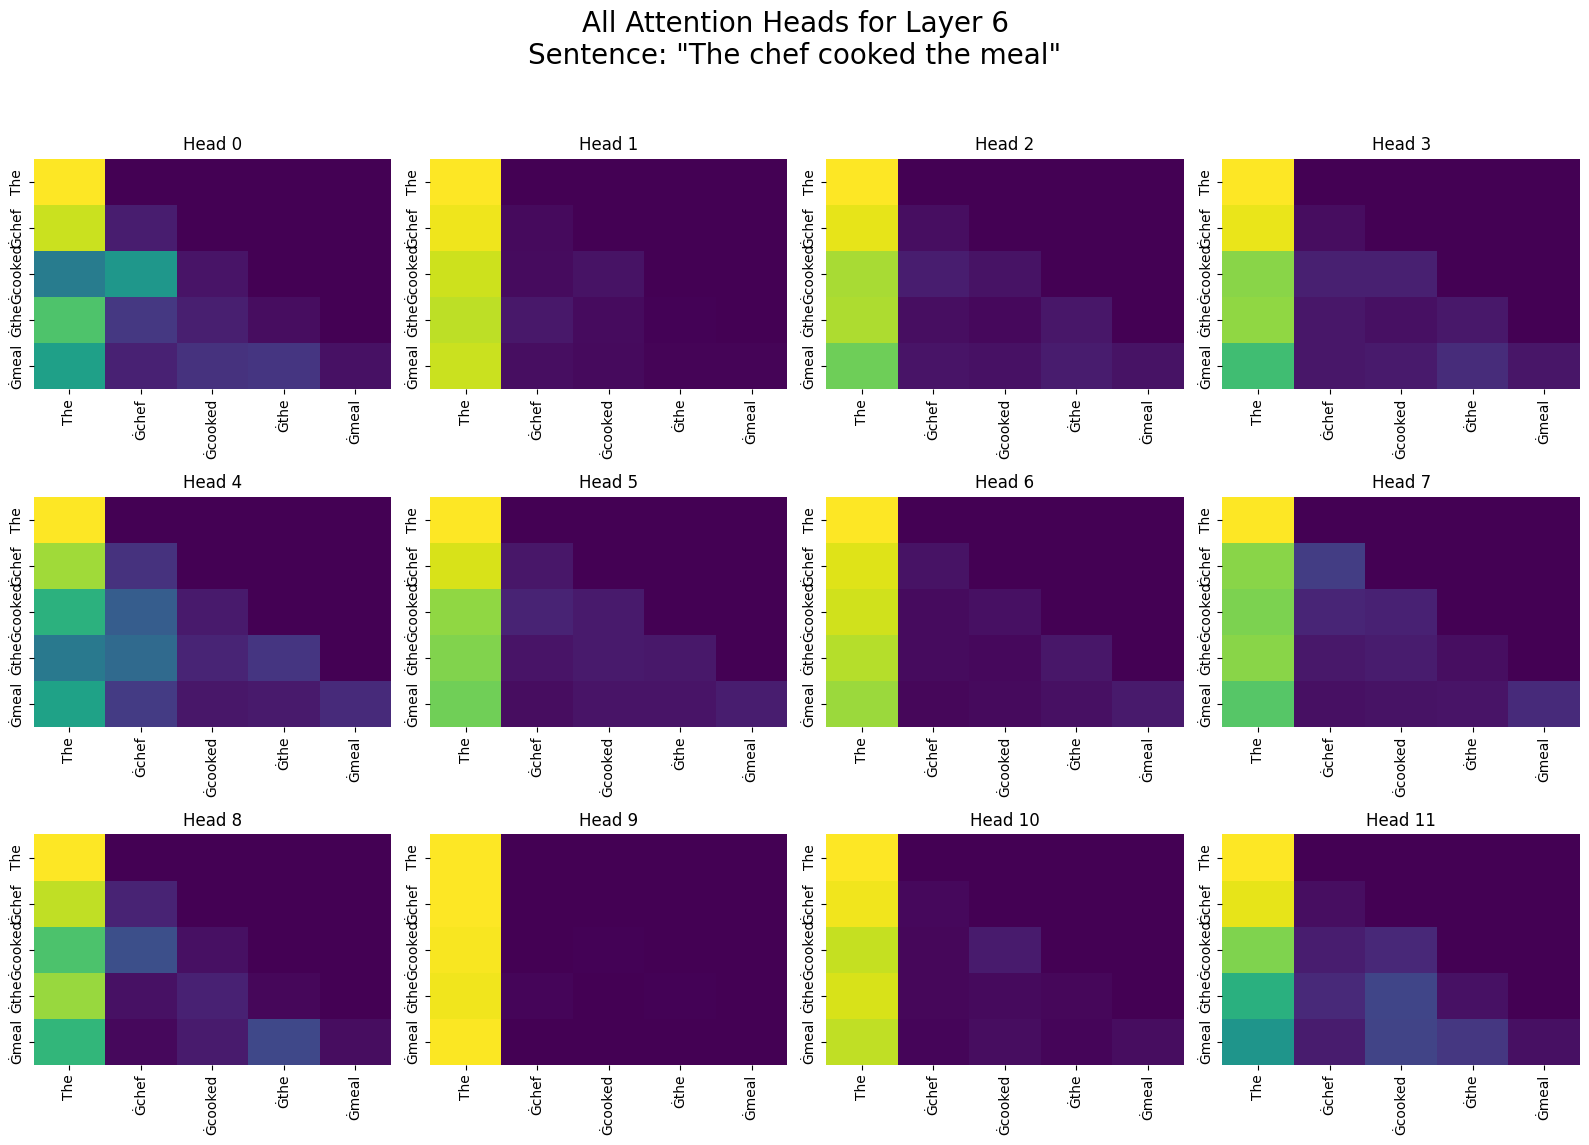


>>> Visualizing Layer 7 for sentence: 'The chef cooked the meal'


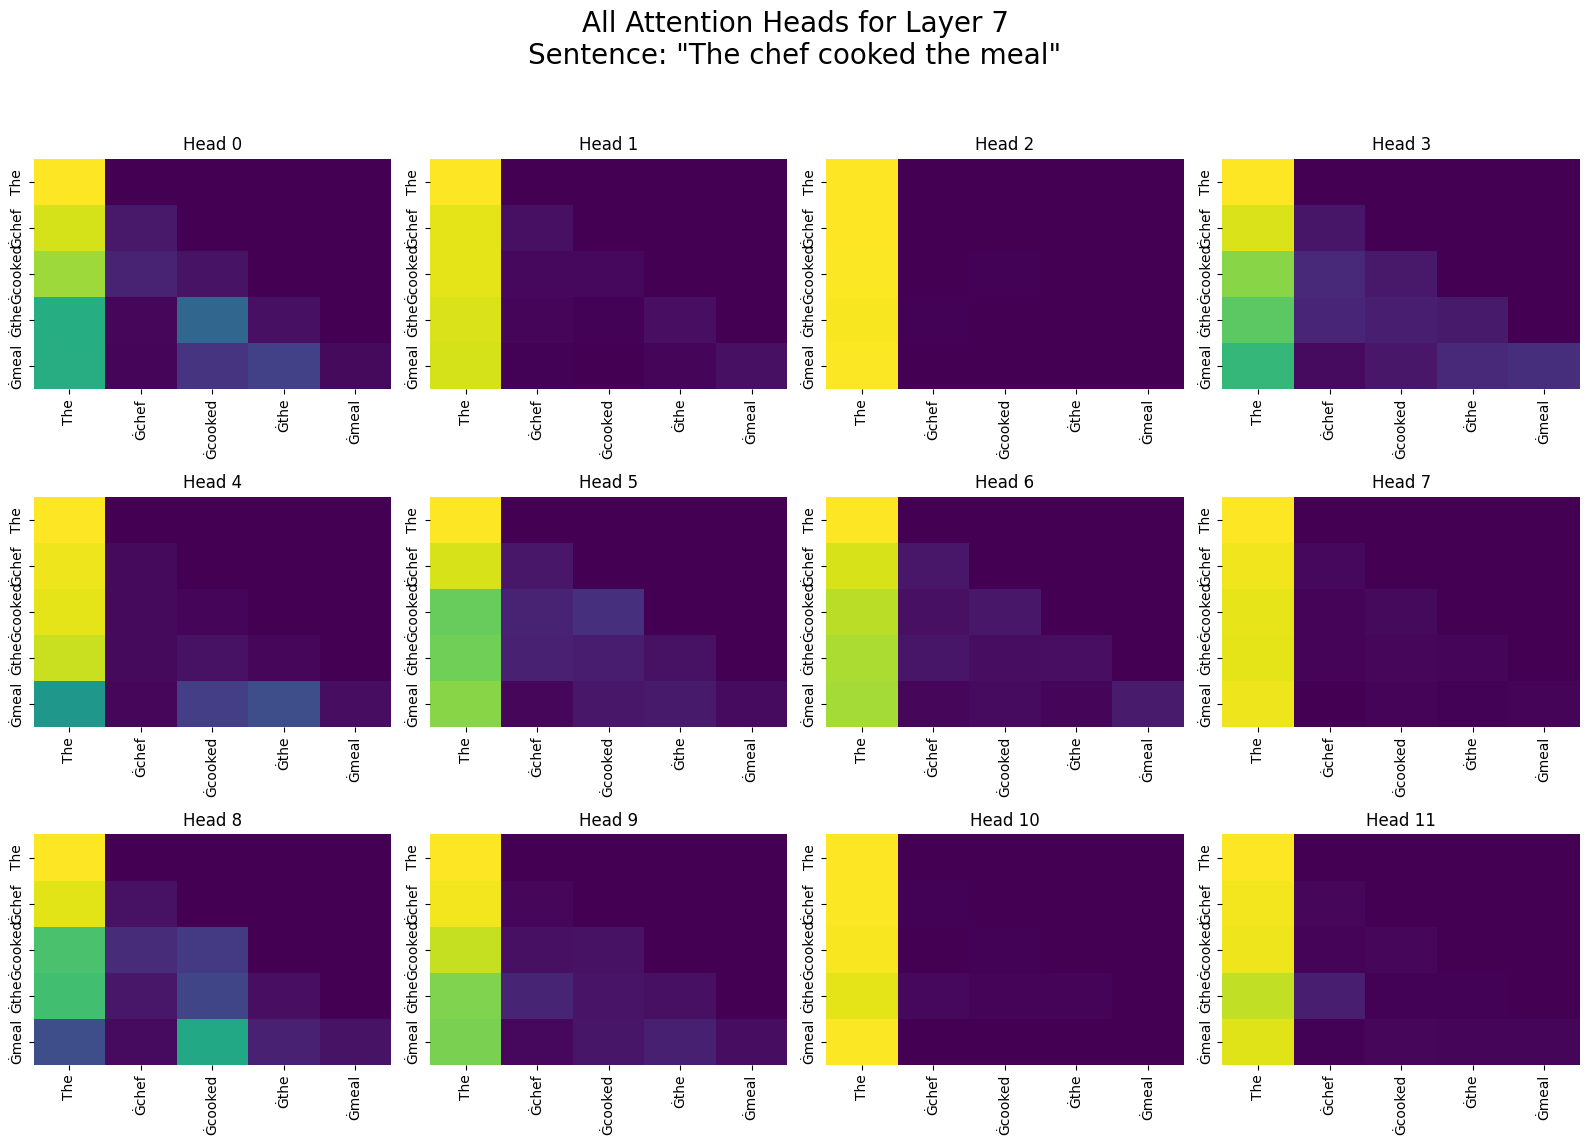


>>> Visualizing Layer 8 for sentence: 'The chef cooked the meal'


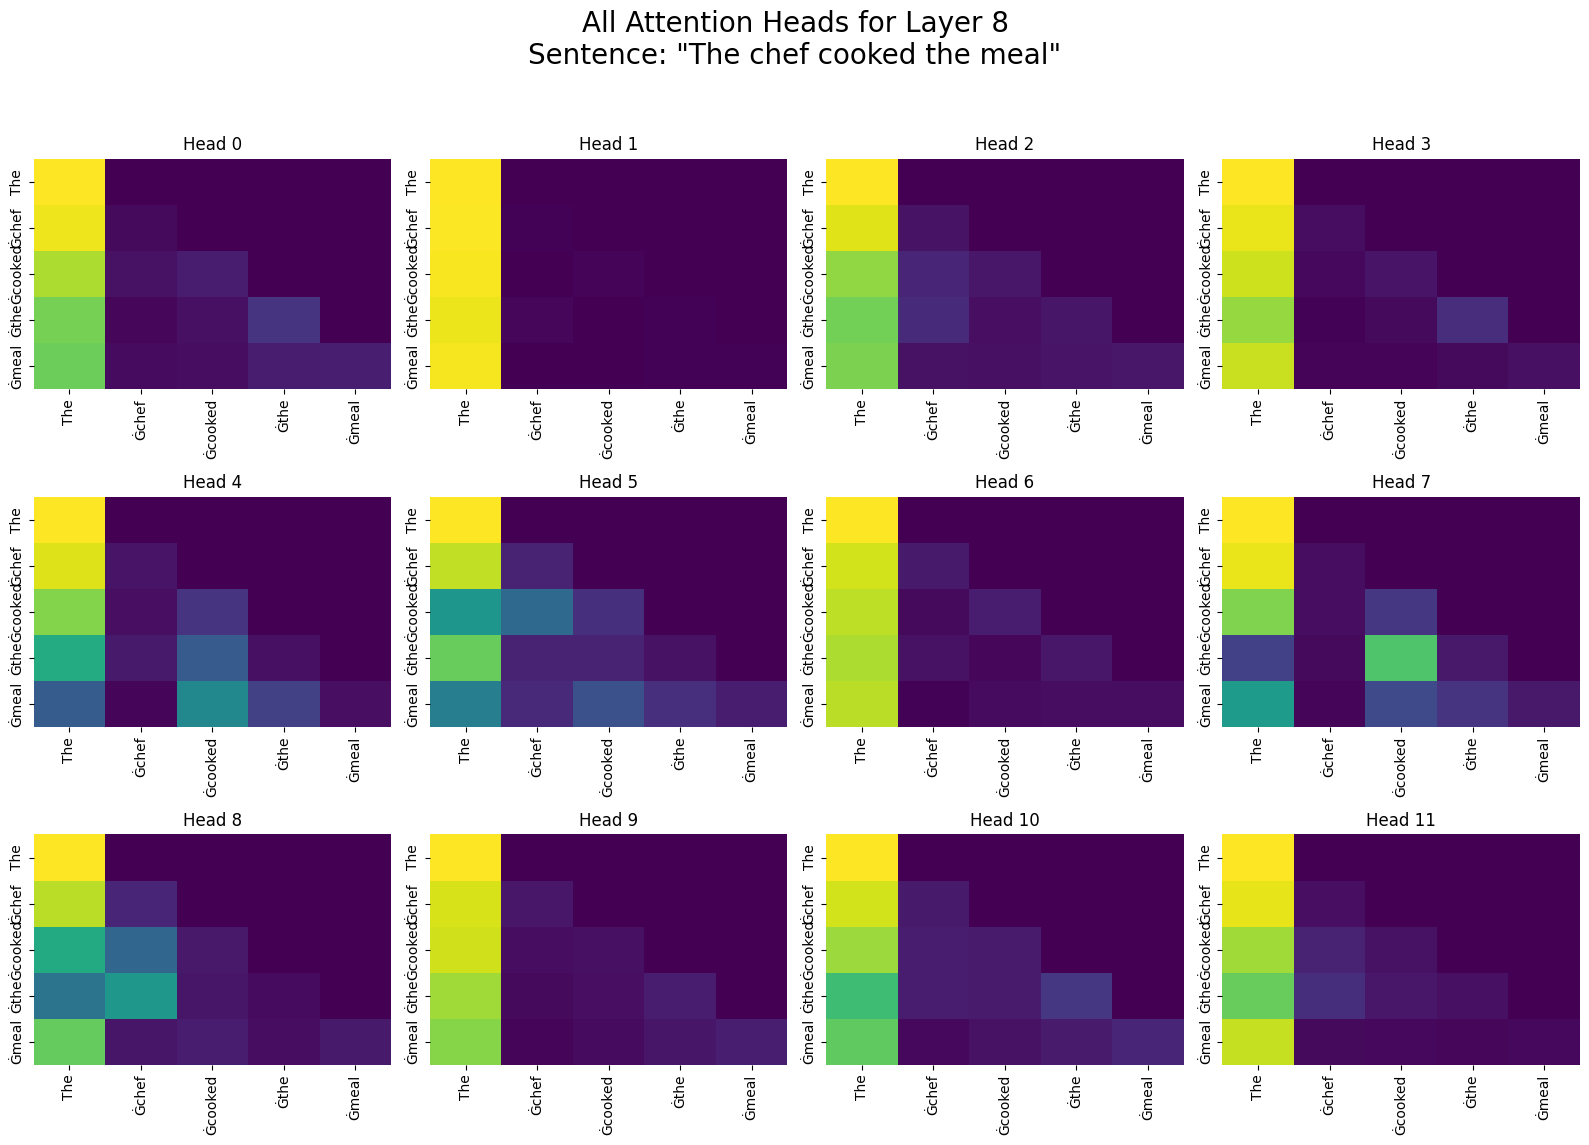


>>> Visualizing Layer 4 for sentence: 'The doctor quickly wrote a prescription'


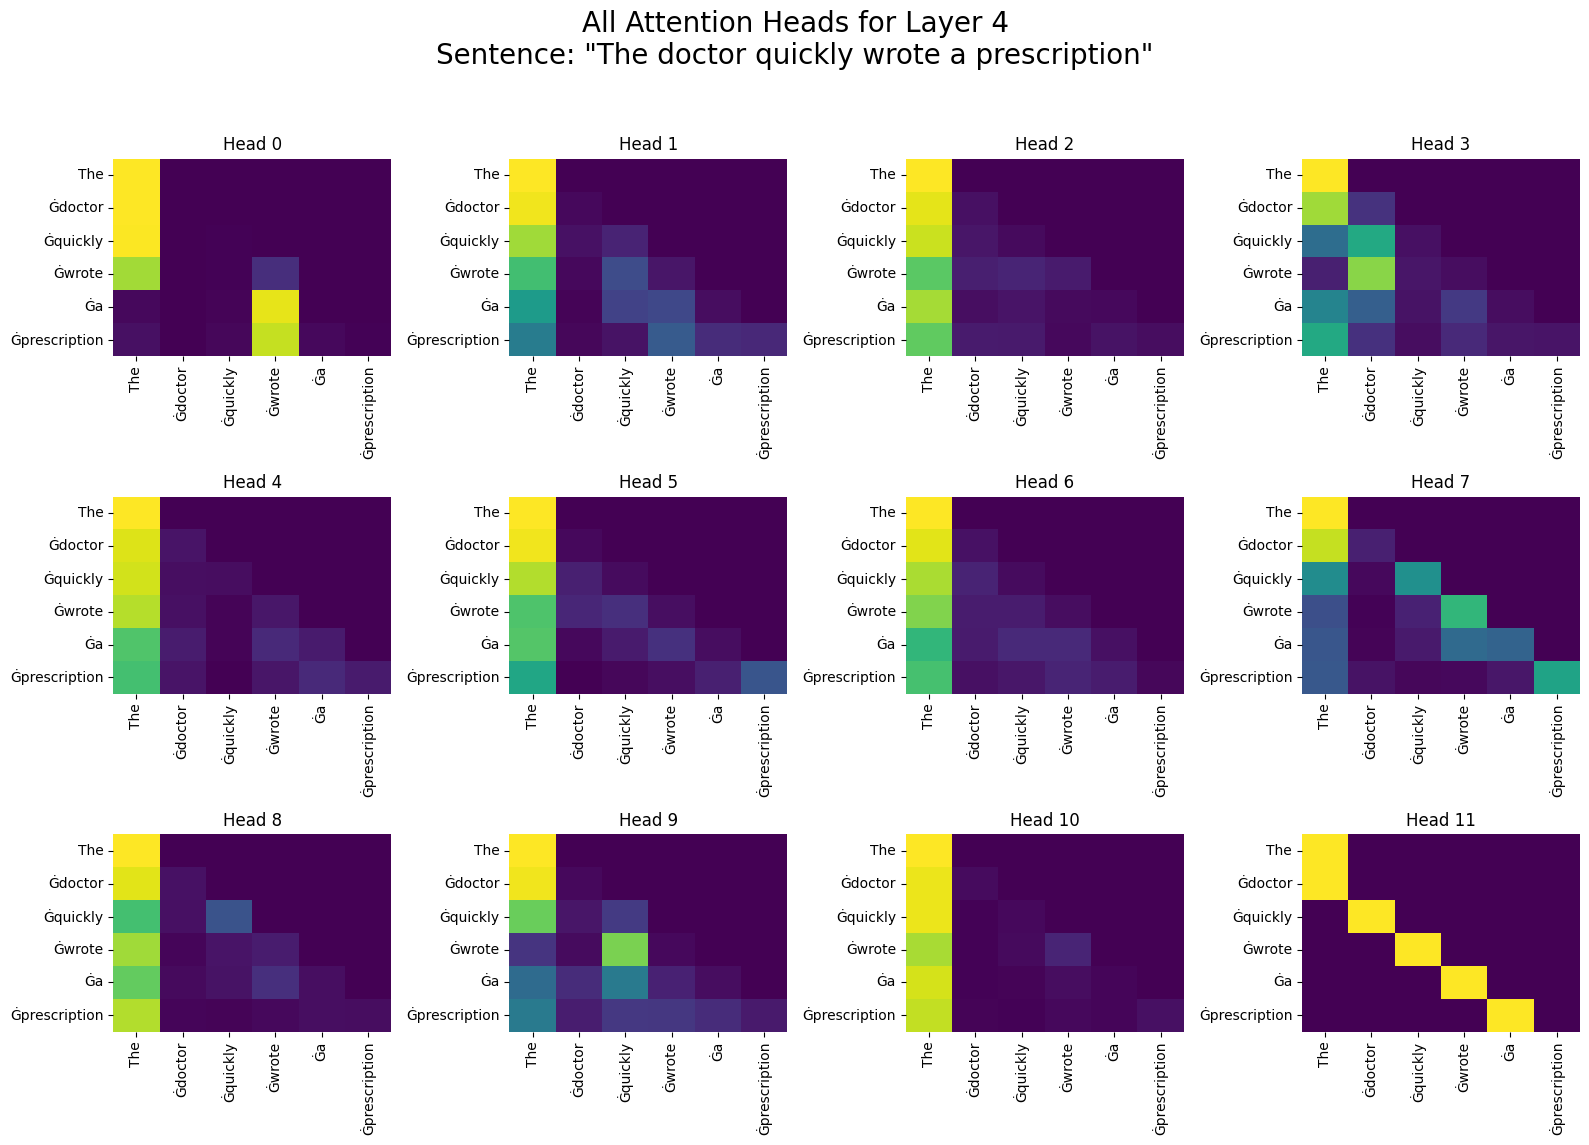


>>> Visualizing Layer 5 for sentence: 'The doctor quickly wrote a prescription'


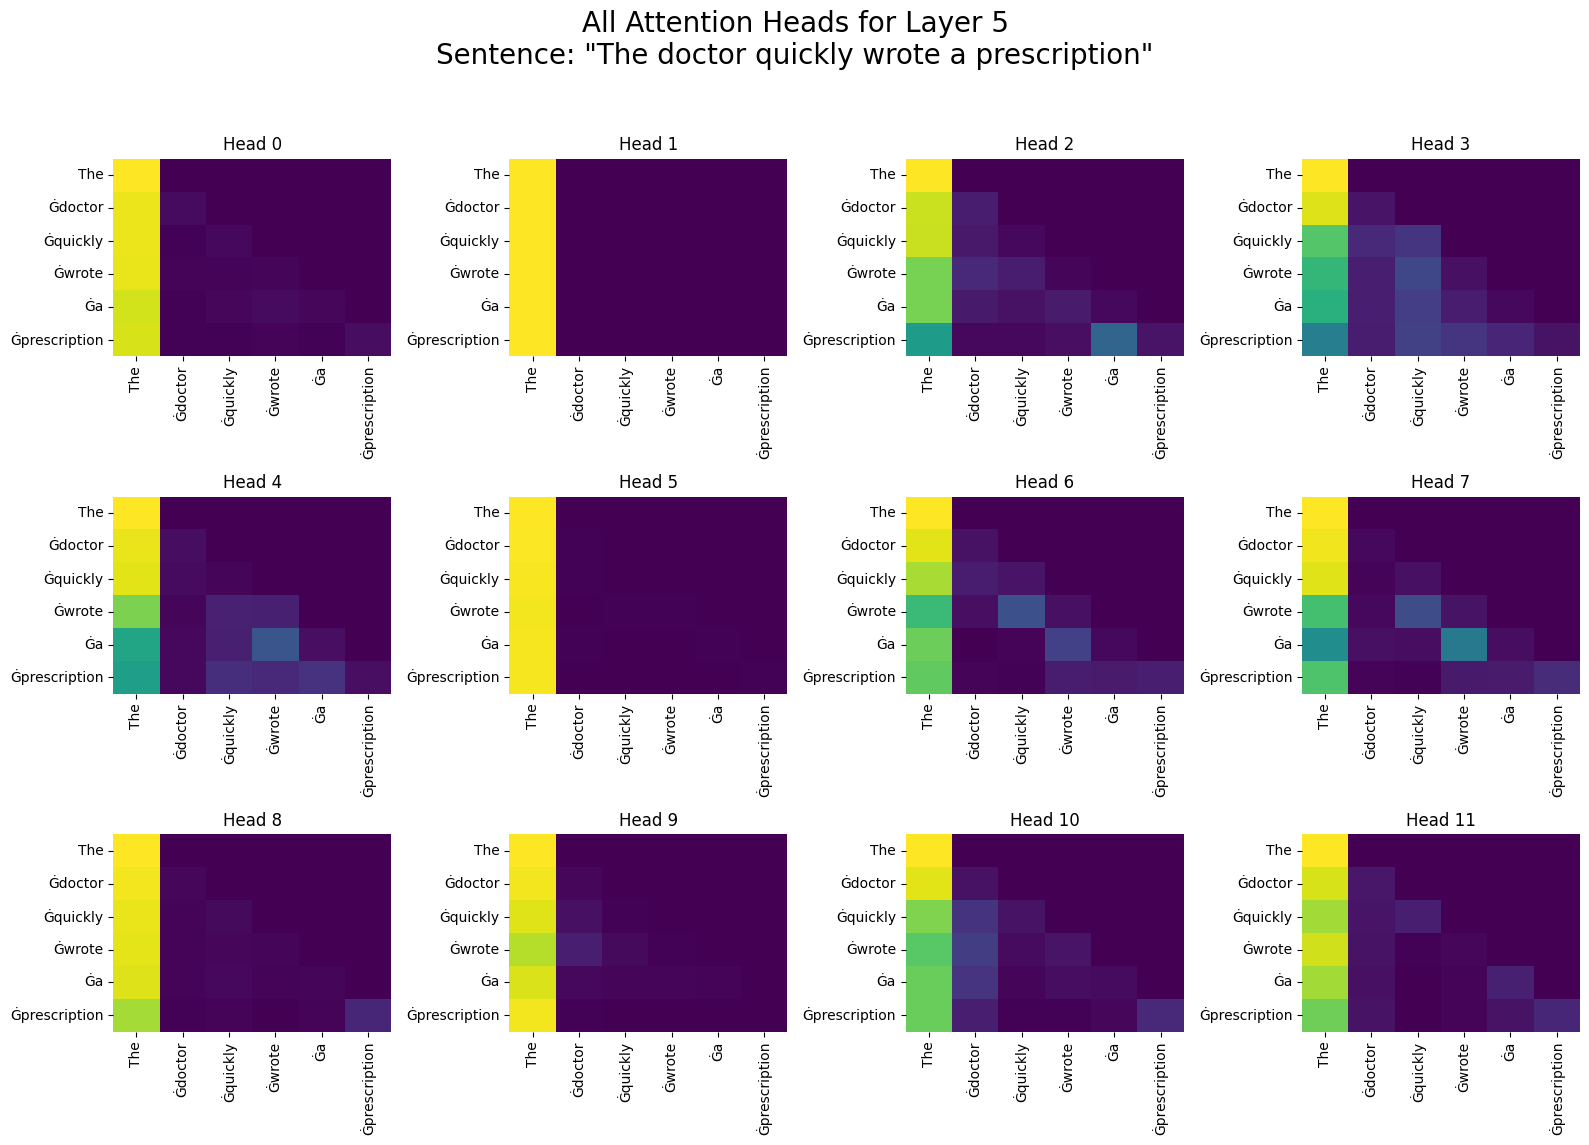


>>> Visualizing Layer 6 for sentence: 'The doctor quickly wrote a prescription'


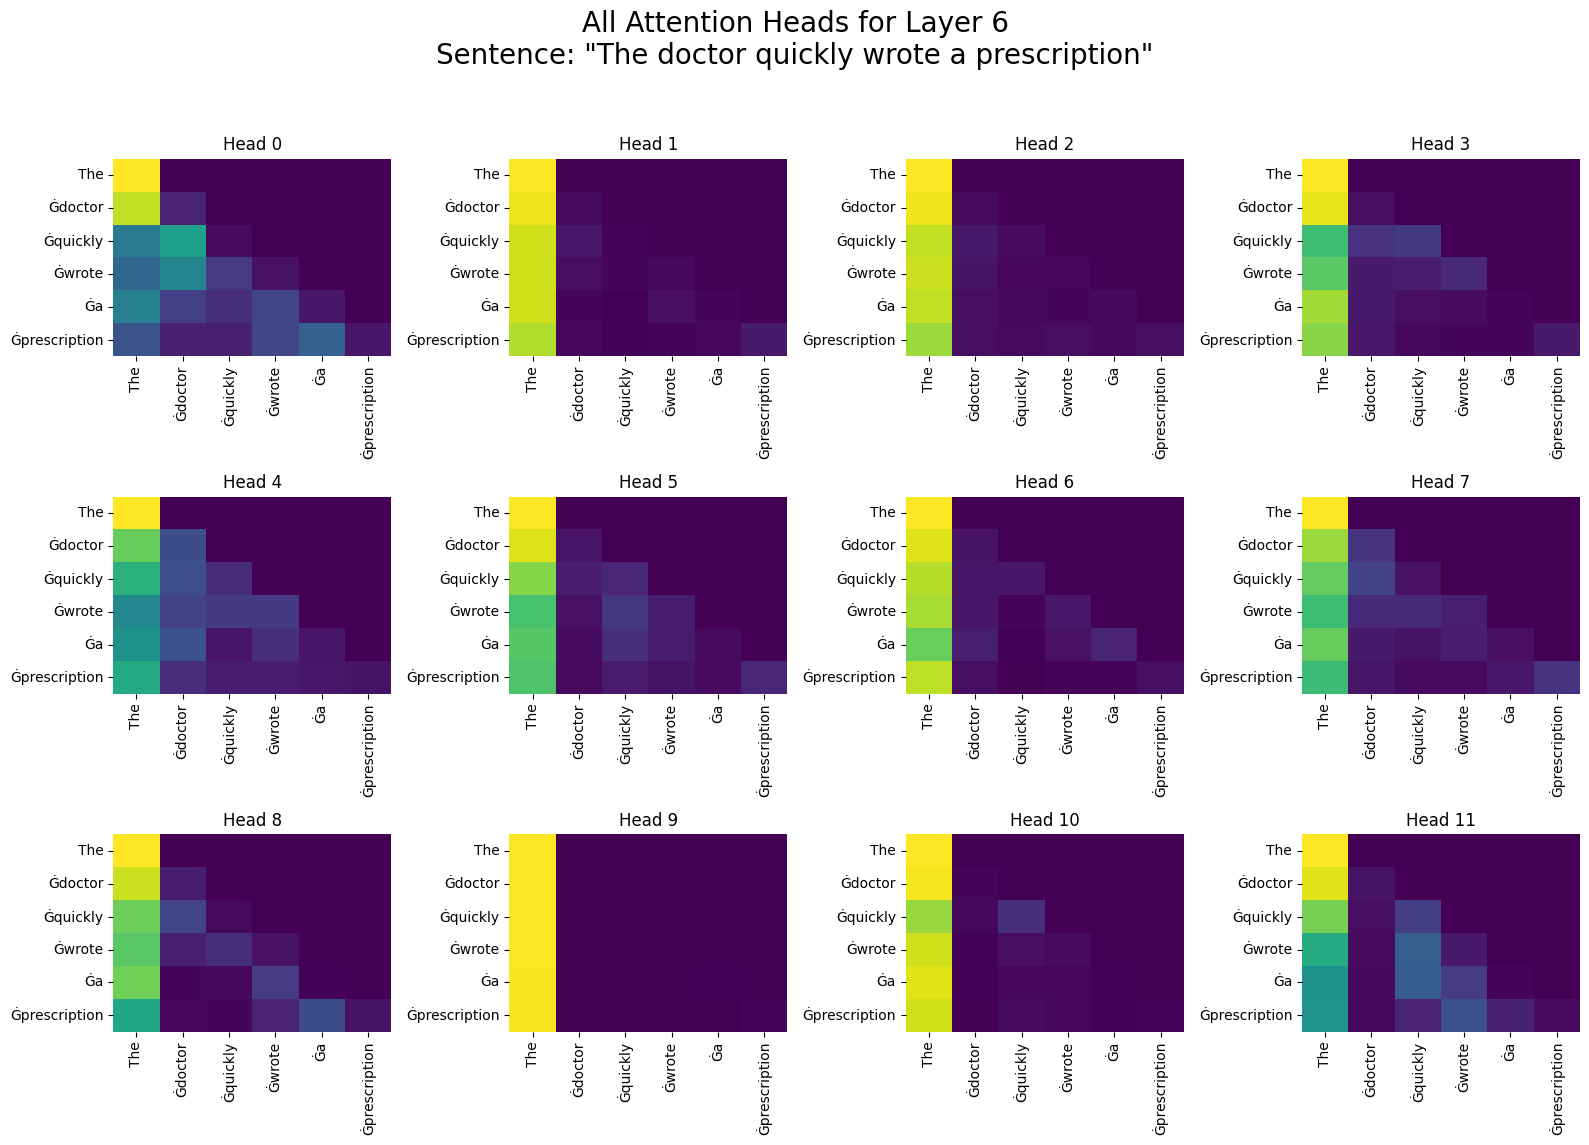


>>> Visualizing Layer 7 for sentence: 'The doctor quickly wrote a prescription'


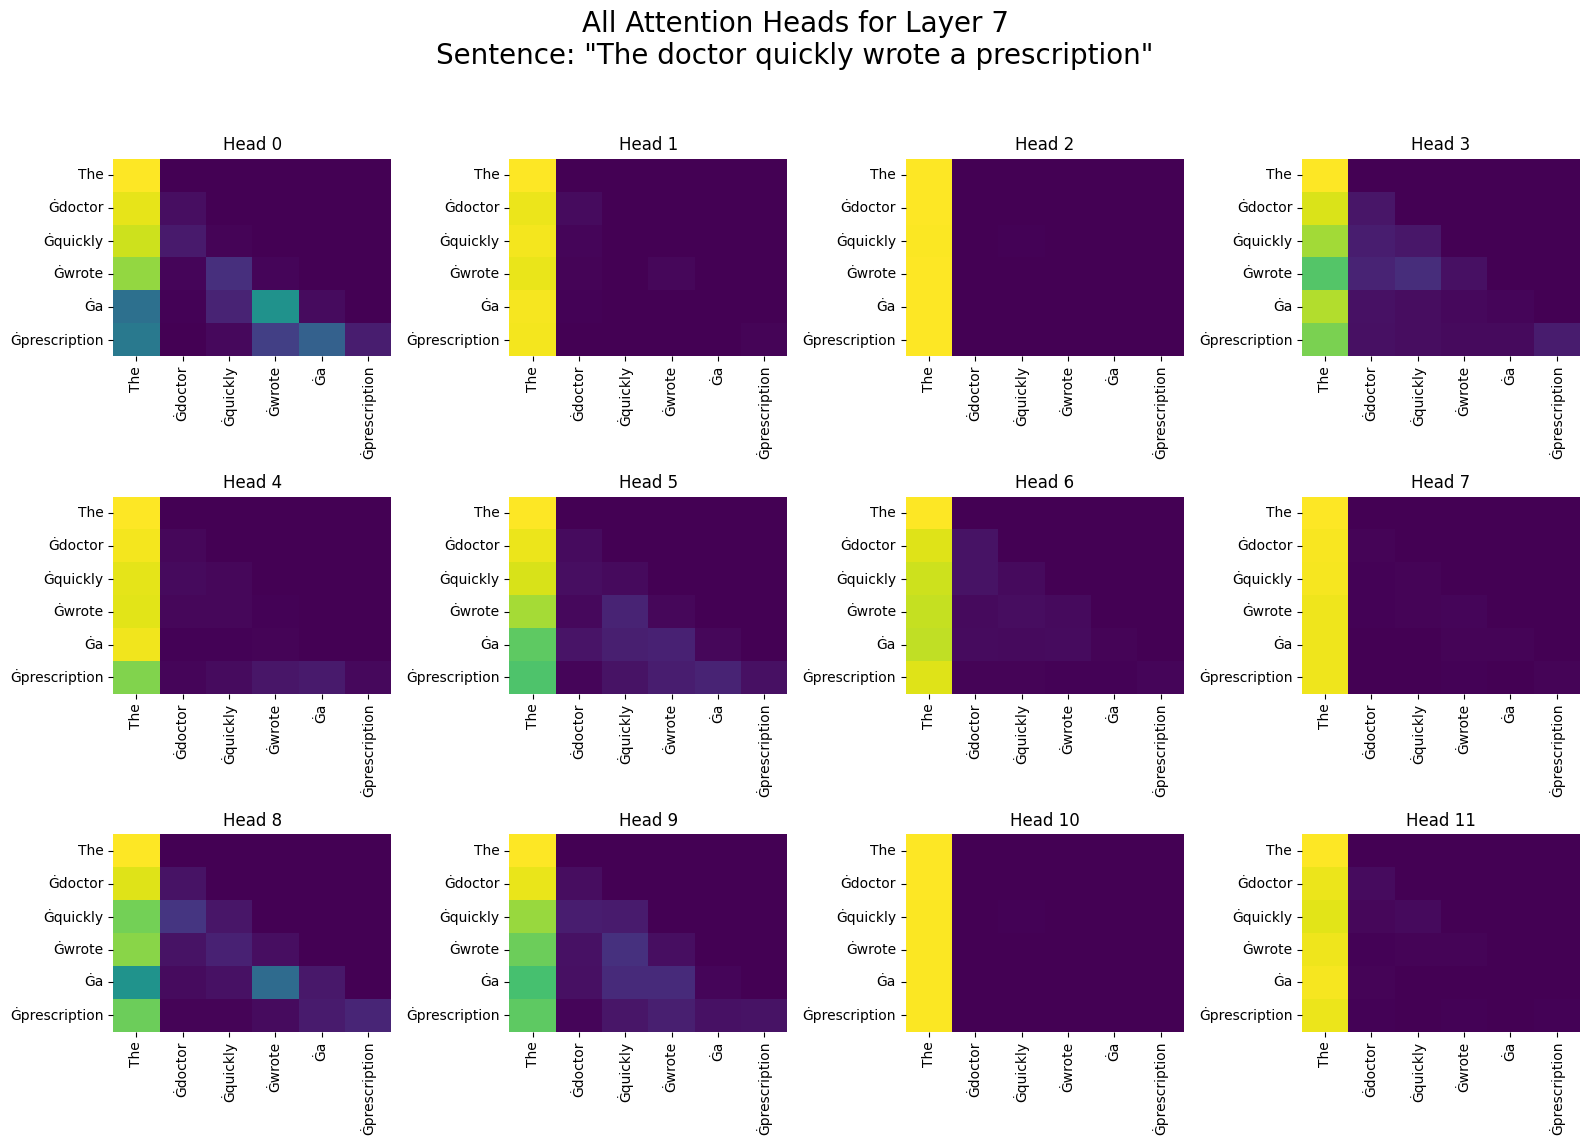


>>> Visualizing Layer 8 for sentence: 'The doctor quickly wrote a prescription'


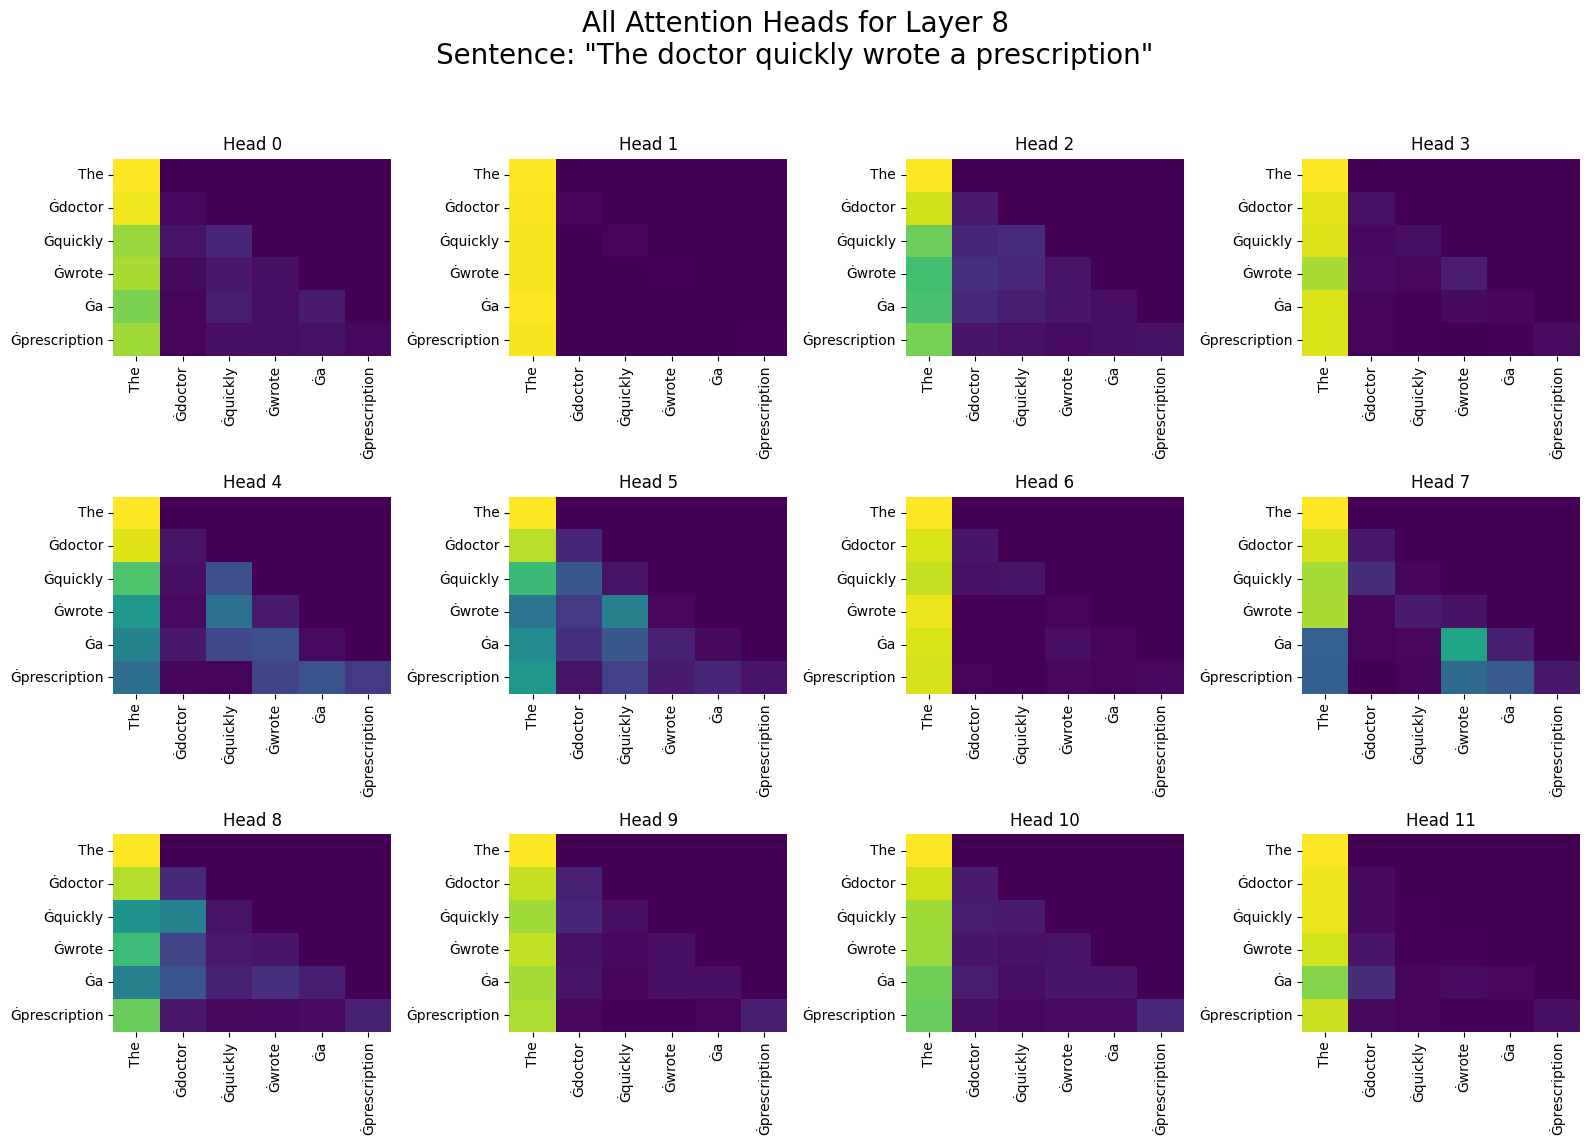


>>> Visualizing Layer 4 for sentence: 'The chef, after a long day, cooked the meal'


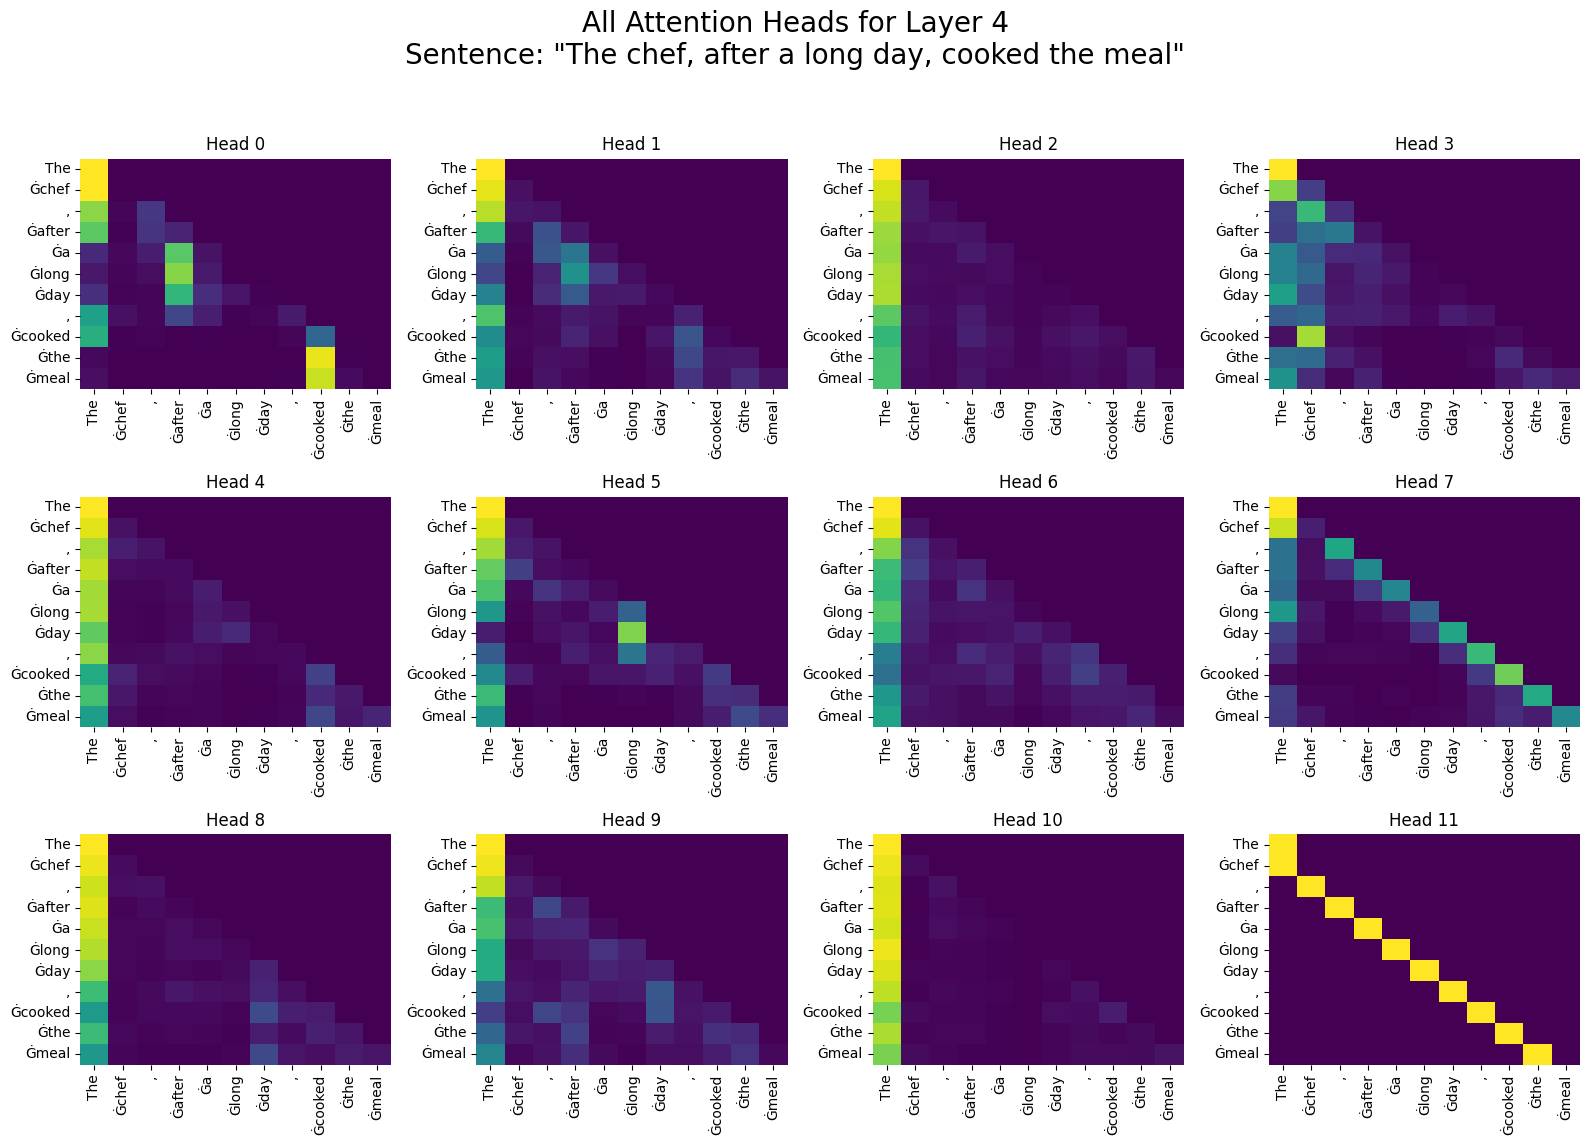


>>> Visualizing Layer 5 for sentence: 'The chef, after a long day, cooked the meal'


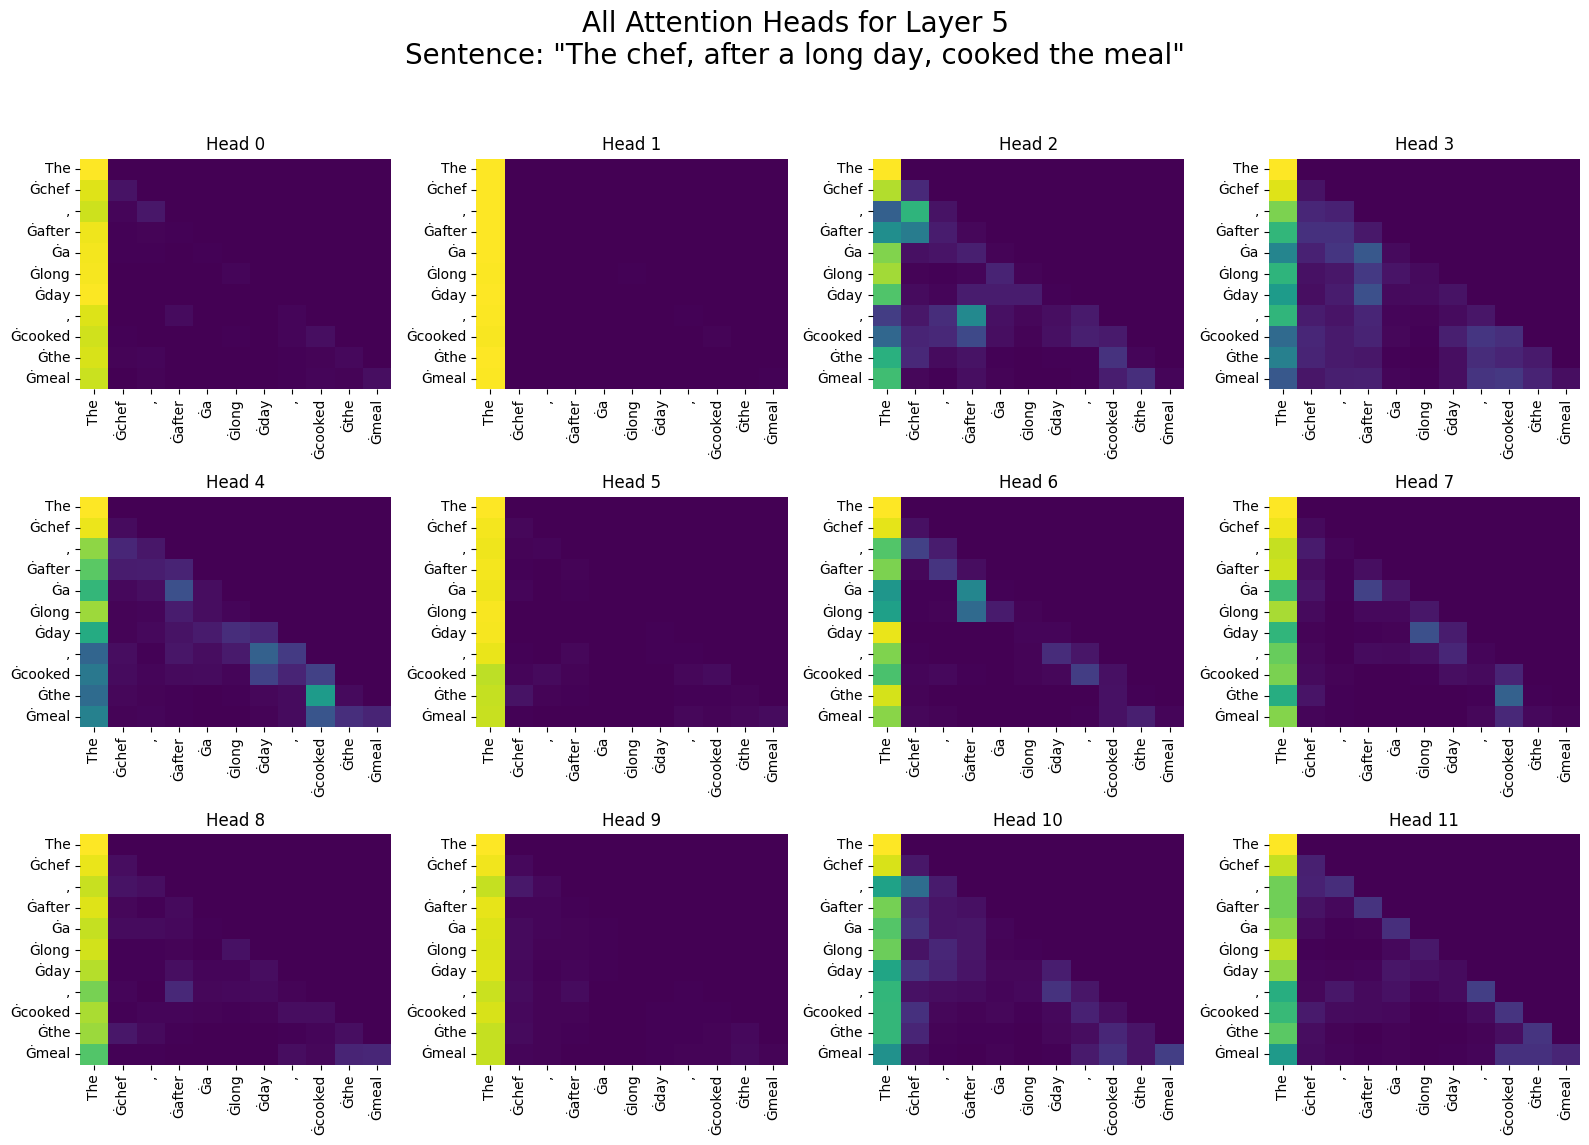


>>> Visualizing Layer 6 for sentence: 'The chef, after a long day, cooked the meal'


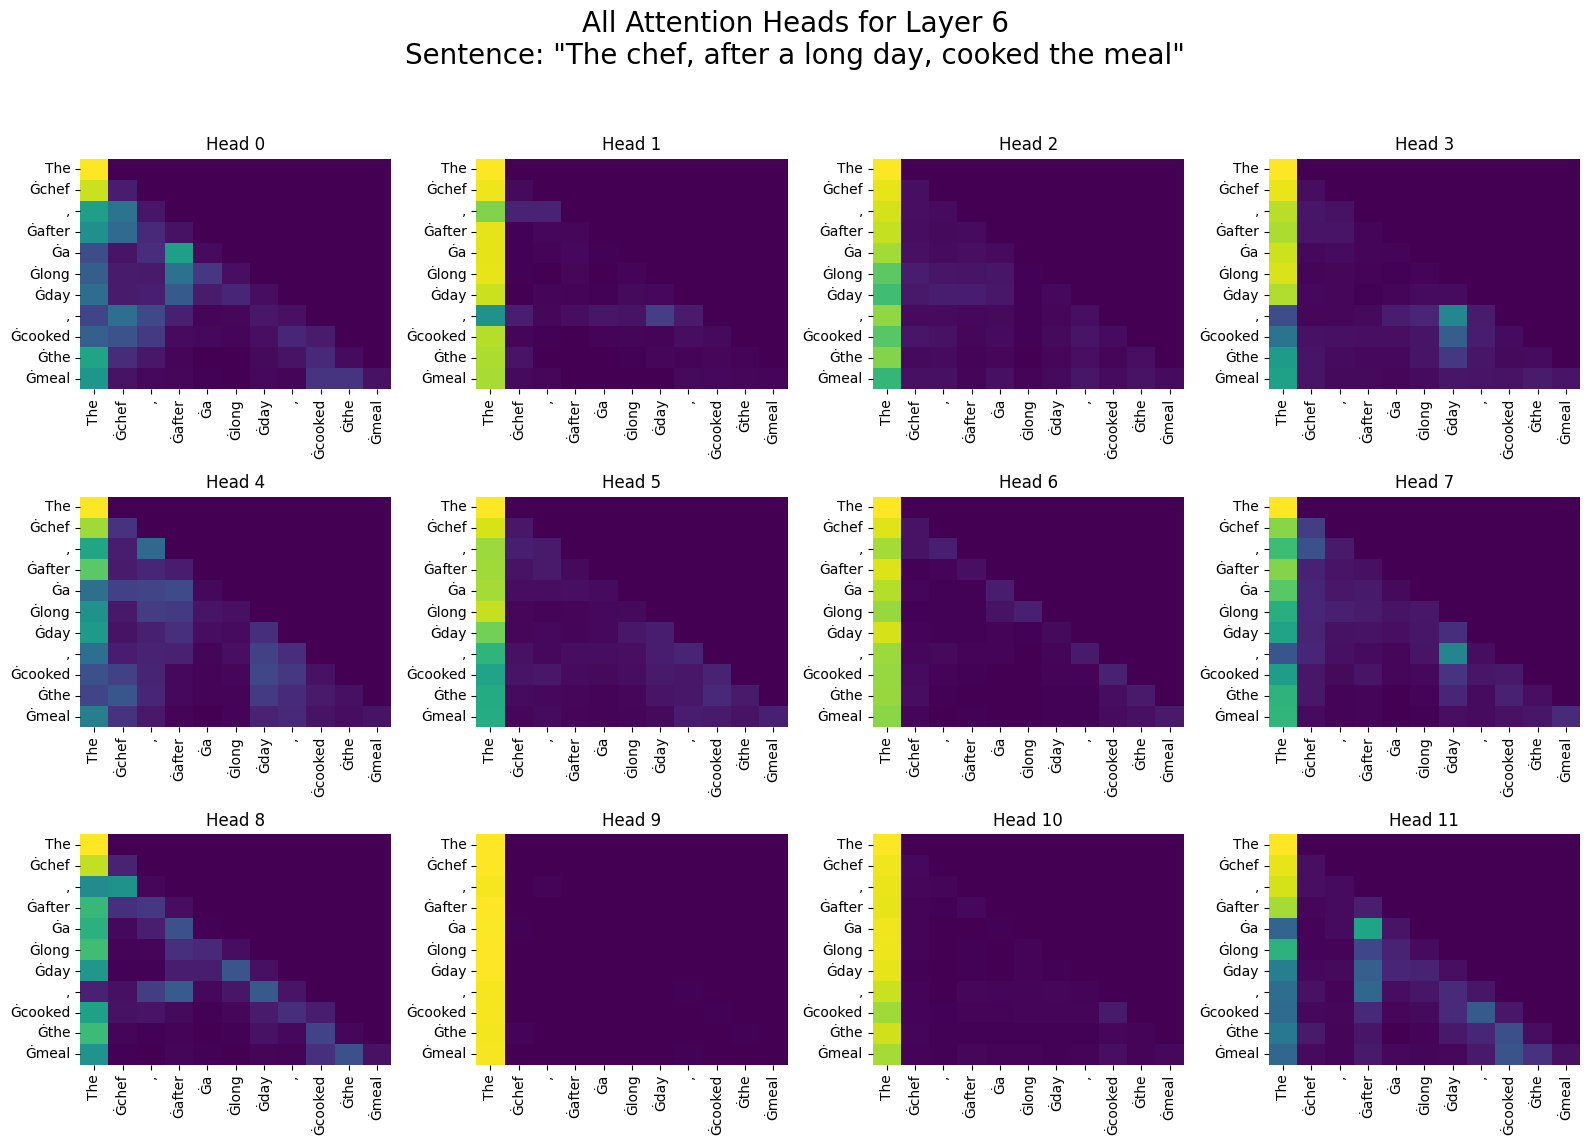


>>> Visualizing Layer 7 for sentence: 'The chef, after a long day, cooked the meal'


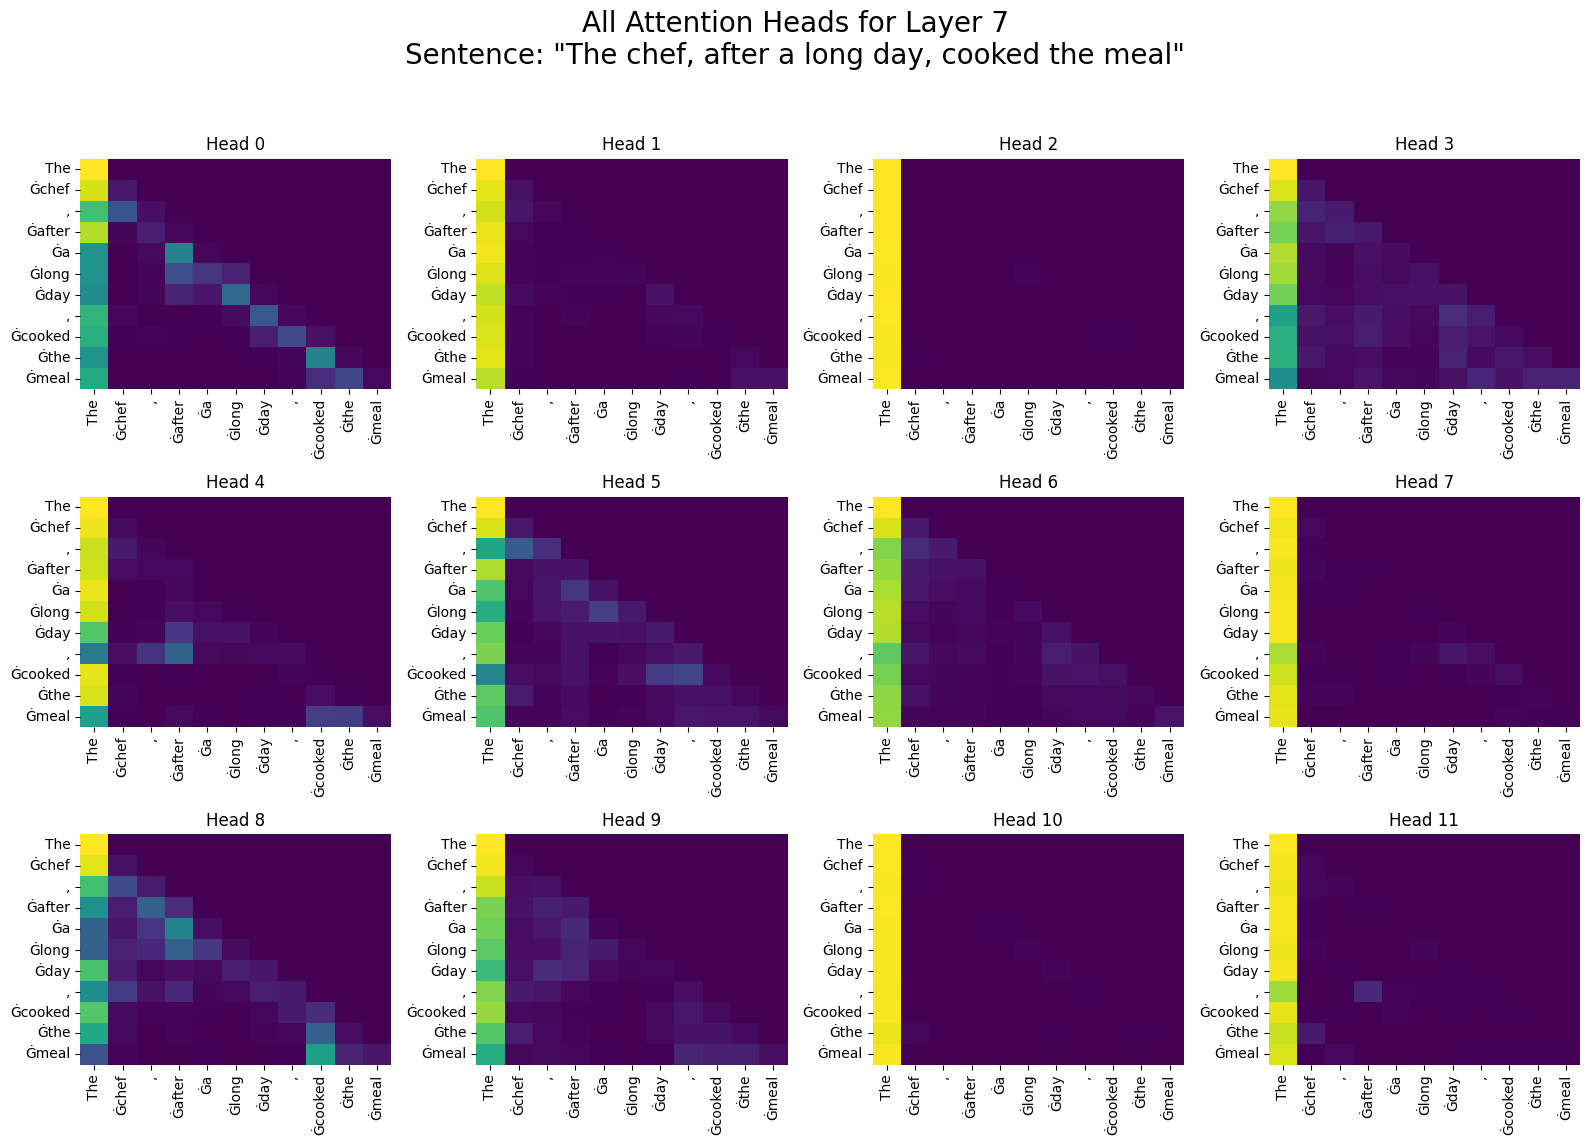


>>> Visualizing Layer 8 for sentence: 'The chef, after a long day, cooked the meal'


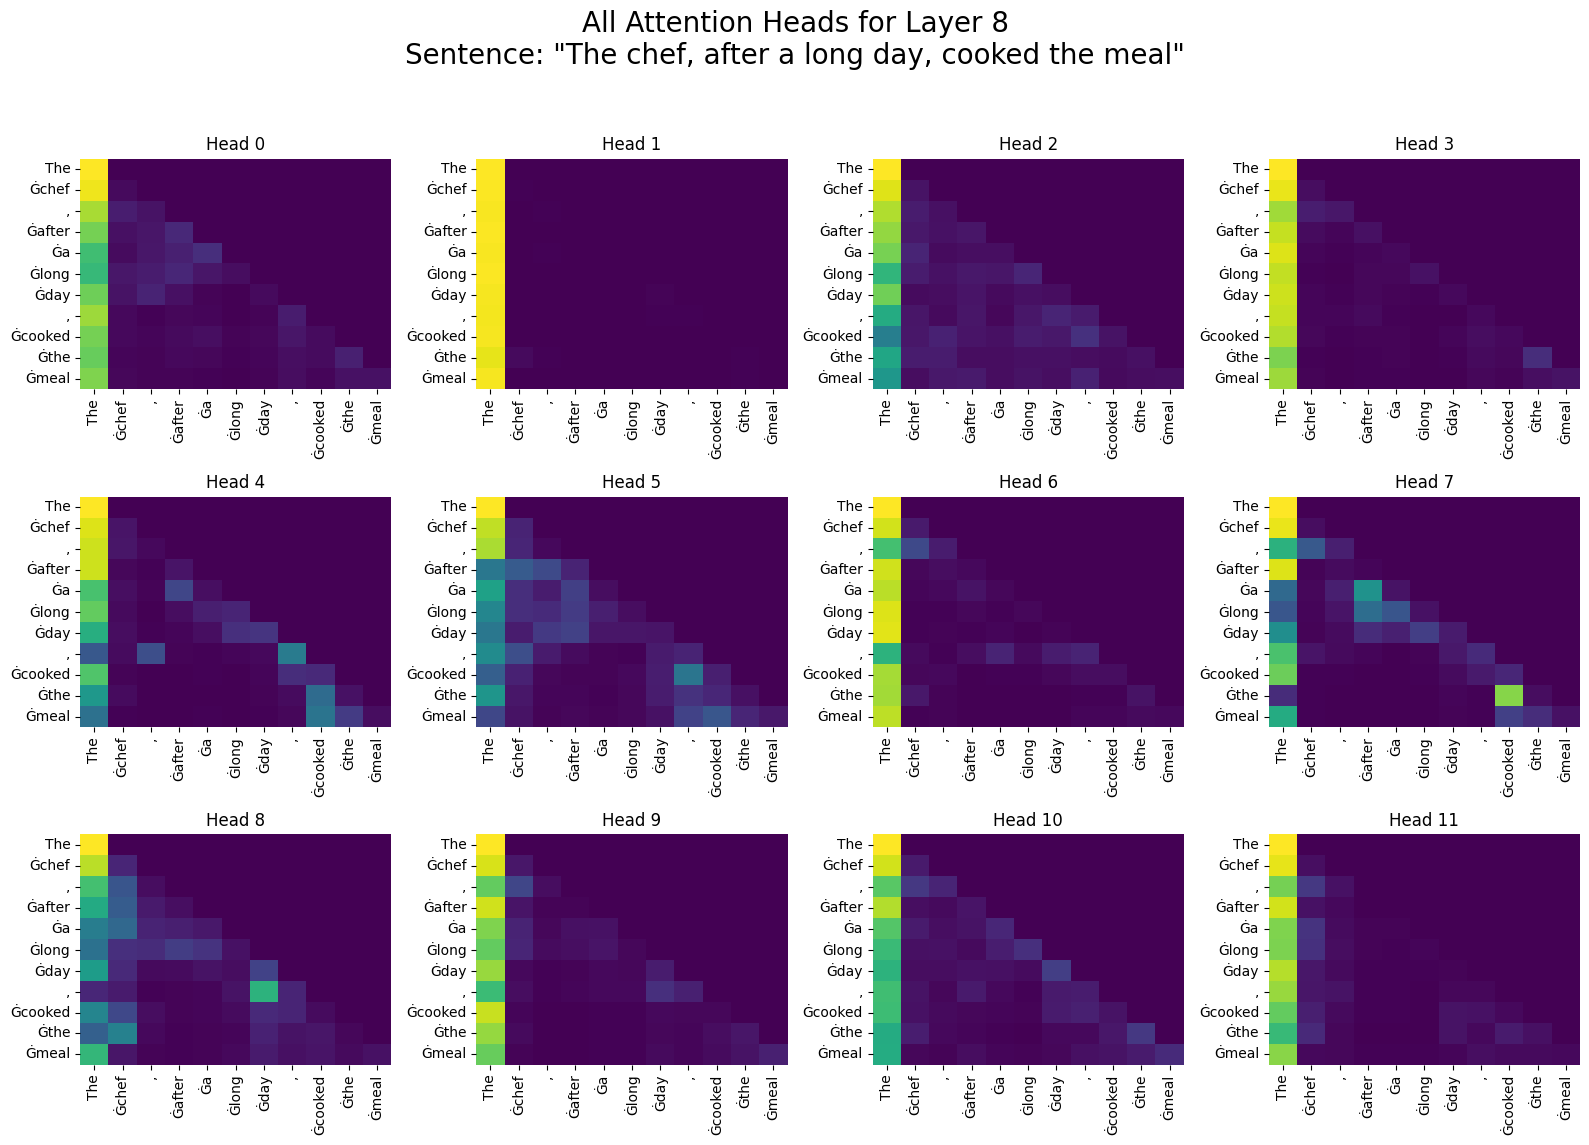

------------------------------------------------------------
--- Probing complete ---


In [53]:
# --- 2. Function to visualize all heads in a layer ---
def visualize_all_heads_in_layer(model, tokenizer, text, layer):
    """Visualizes the attention patterns for all heads in a specified layer."""
    inputs = tokenizer(text, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    
    attention = outputs.attentions[layer].squeeze(0).detach().numpy()
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    # Add a main title that includes the sentence being analyzed
    fig.suptitle(f'All Attention Heads for Layer {layer}\nSentence: "{text}"', fontsize=20)
    
    for head in range(12):
        row, col = head // 4, head % 4
        ax = axes[row, col]
        
        sns.heatmap(attention[head], xticklabels=tokens, yticklabels=tokens, cmap='viridis', ax=ax, cbar=False)
        ax.set_title(f'Head {head}')
        ax.tick_params(axis='x', rotation=90)
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for the suptitle
    plt.show()

# --- 3. Main Execution Block for Probing ---
if __name__ == "__main__":
    # Step 1: Define the hypothesis and create the test set
    test_set = [
        "The doctor wrote a prescription",
        "The chef cooked the meal",
        
        "The doctor quickly wrote a prescription",
        "The chef, after a long day, cooked the meal"
    ]
    
    # Define the middle layers we want to investigate
    layers_to_probe = range(4, 9) # This will check layers 4, 5, 6, 7, and 8
    
    print("--- Starting the hunt for subject-verb attention heads ---")
    print(f"Analyzing {len(test_set)} sentences across {len(layers_to_probe)} layers.")
    print("Look for heads that consistently highlight the subject from the verb's position.")
    print("-" * 60)

    # Step 2: Iterate through the test set and layers to find candidate heads
    # NOTE: This will generate many plots (one window for each sentence/layer combination).
    for sentence in test_set:
        for layer in layers_to_probe:
            print(f"\n>>> Visualizing Layer {layer} for sentence: '{sentence}'")
            visualize_all_heads_in_layer(model, tokenizer, sentence, layer)

    print("-" * 60)
    print("--- Probing complete ---")

Variable Distance Testing

In [54]:
# --- 2. Function to Print Specific Attention Scores ---
def print_attention_scores(model, tokenizer, text, layer, query_word, key_word):
    """
    Calculates and prints the specific attention score from a query_word to a key_word
    for all heads in a given layer.
    """
    inputs = tokenizer(text, return_tensors='pt')
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    
    try:
        try:
            query_idx = tokens.index('Ġ' + query_word)
        except ValueError:
            query_idx = tokens.index(query_word)
            
        try:
            key_idx = tokens.index('Ġ' + key_word)
        except ValueError:
            key_idx = tokens.index(key_word)
            
    except ValueError as e:
        print(f"Error: A token was not found. Tokens are: {tokens}. Error: {e}")
        return

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    
    attention = outputs.attentions[layer].squeeze(0)
    
    print(f"--- Scores for sentence: '{text}' in Layer {layer} ---")
    print(f"Attention from '{tokens[query_idx]}' (pos {query_idx}) to '{tokens[key_idx]}' (pos {key_idx}):\n")
    
    for head_idx in range(12):
        score = attention[head_idx, query_idx, key_idx].item()
        print(f"Head {head_idx:02d}: {score:.4f}")

# --- 3. Main Execution Block ---
if __name__ == "__main__":
    # Test set where the distance between subject and verb is varied.
    variable_distance_test_cases = [
        {"sentence": "The doctor wrote a prescription", "verb": "wrote", "subject": "doctor"}, # 0 words between
        {"sentence": "The doctor quickly wrote a prescription", "verb": "wrote", "subject": "doctor"}, # 1 word between
        {"sentence": "The doctor very quickly wrote a prescription", "verb": "wrote", "subject": "doctor"}, # 2 words between
        {"sentence": "The doctor who arrived late wrote a prescription", "verb": "wrote", "subject": "doctor"} # 4 words between
    ]
    
    target_layer = 4
    
    for case in variable_distance_test_cases:
        print_attention_scores(
            model, 
            tokenizer, 
            text=case["sentence"], 
            layer=target_layer, 
            query_word=case["verb"], 
            key_word=case["subject"]
        )
        print("-" * 50)

--- Scores for sentence: 'The doctor wrote a prescription' in Layer 4 ---
Attention from 'Ġwrote' (pos 2) to 'Ġdoctor' (pos 1):

Head 00: 0.0023
Head 01: 0.0247
Head 02: 0.0955
Head 03: 0.9021
Head 04: 0.0681
Head 05: 0.0961
Head 06: 0.0944
Head 07: 0.0159
Head 08: 0.0263
Head 09: 0.1543
Head 10: 0.0063
Head 11: 0.9999
--------------------------------------------------
--- Scores for sentence: 'The doctor quickly wrote a prescription' in Layer 4 ---
Attention from 'Ġwrote' (pos 3) to 'Ġdoctor' (pos 1):

Head 00: 0.0022
Head 01: 0.0199
Head 02: 0.0824
Head 03: 0.8234
Head 04: 0.0400
Head 05: 0.1084
Head 06: 0.0774
Head 07: 0.0072
Head 08: 0.0145
Head 09: 0.0277
Head 10: 0.0050
Head 11: 0.0000
--------------------------------------------------
--- Scores for sentence: 'The doctor very quickly wrote a prescription' in Layer 4 ---
Attention from 'Ġwrote' (pos 4) to 'Ġdoctor' (pos 1):

Head 00: 0.0025
Head 01: 0.0167
Head 02: 0.0994
Head 03: 0.8219
Head 04: 0.0467
Head 05: 0.0945
Head 06: 0

In [55]:
# --- 2. Enhanced Analysis Functions ---
def get_next_token_probabilities(model, tokenizer, text, top_k=5):
    """Get the top-k most likely next tokens and their probabilities."""
    inputs = tokenizer(text, return_tensors='pt')
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits[0, -1, :]  # Last token's logits
        probs = F.softmax(logits, dim=-1)
        
    top_probs, top_indices = torch.topk(probs, top_k)
    
    results = []
    for prob, idx in zip(top_probs, top_indices):
        token = tokenizer.decode(idx)
        results.append((token, prob.item()))
    
    return results

def analyze_pronoun_resolution(model, tokenizer, base_text):
    """Analyze what the model predicts for pronoun resolution."""
    print(f"Analyzing: '{base_text}'")
    print("Top 5 next token predictions:")
    
    predictions = get_next_token_probabilities(model, tokenizer, base_text)
    for i, (token, prob) in enumerate(predictions):
        print(f"{i+1}. '{token}' (prob: {prob:.4f})")
    print()

# --- 3. More Targeted Ablation Hook ---
layer_to_ablate = -1
heads_to_ablate = []

def attention_ablation_hook(module, input, output):
    """Hook that zeros out specific attention heads."""
    attn_output = output[0]  # [batch, seq_len, hidden_size]
    
    # GPT-2 has 768 hidden dimensions, 12 heads, so 64 dims per head
    head_dim = 768 // 12
    
    for head_idx in heads_to_ablate:
        start_idx = head_idx * head_dim
        end_idx = start_idx + head_dim
        attn_output[:, :, start_idx:end_idx] = 0
    
    return (attn_output,) + output[1:]

# --- 4. Test Different Scenarios ---
def test_ablation_effects():
    test_cases = [
        "The doctor quickly wrote a prescription because he",
        "The nurse carefully prepared the medication and she", 
        "The teacher explained the lesson and he",
        "The woman opened the door because she"
    ]
    
    ablation_configs = [
        {"layer": 4, "heads": [3], "name": "Head 3 only"},
        {"layer": 4, "heads": [11], "name": "Head 11 only"}, 
        {"layer": 4, "heads": [3, 11], "name": "Heads 3 & 11"},
        {"layer": 4, "heads": [3, 5, 9, 11], "name": "Multiple heads"}
    ]
    
    for case in test_cases:
        print("=" * 80)
        print(f"TEST CASE: {case}")
        print("=" * 80)
        
        # Baseline
        print("BASELINE (No ablation):")
        analyze_pronoun_resolution(model, tokenizer, case)
        
        # Test different ablations
        for config in ablation_configs:
            print(f"ABLATION - {config['name']} (Layer {config['layer']}):")
            
            global layer_to_ablate, heads_to_ablate
            layer_to_ablate = config['layer']
            heads_to_ablate = config['heads']
            
            # Register hook
            hook = model.transformer.h[layer_to_ablate].attn.register_forward_hook(attention_ablation_hook)
            
            try:
                analyze_pronoun_resolution(model, tokenizer, case)
            finally:
                hook.remove()
        
        print("\n")

# --- 5. Detailed Attention Pattern Analysis ---
def analyze_attention_patterns(text, target_layer=4):
    """Analyze attention patterns to understand information flow."""
    inputs = tokenizer(text, return_tensors='pt')
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    
    attention = outputs.attentions[target_layer].squeeze(0)  # [n_heads, seq_len, seq_len]
    
    print(f"Attention analysis for: '{text}'")
    print(f"Tokens: {tokens}")
    print(f"Layer {target_layer} attention patterns:\n")
    
    # Find the last token (where we want to predict next)
    last_pos = len(tokens) - 1
    
    print(f"What does the last token '{tokens[last_pos]}' (pos {last_pos}) attend to:")
    for head_idx in range(12):
        print(f"\nHead {head_idx}:")
        head_attention = attention[head_idx, last_pos, :]
        
        # Show top 3 attended tokens
        top_vals, top_indices = torch.topk(head_attention, min(3, len(tokens)))
        for val, idx in zip(top_vals, top_indices):
            print(f"  -> '{tokens[idx]}' (pos {idx}): {val:.4f}")

# --- 6. Main Execution ---
if __name__ == "__main__":
    print("Testing ablation effects on pronoun resolution...")
    test_ablation_effects()
    
    print("\n" + "="*80)
    print("DETAILED ATTENTION ANALYSIS")
    print("="*80)
    analyze_attention_patterns("The doctor quickly wrote a prescription because he")

Testing ablation effects on pronoun resolution...
TEST CASE: The doctor quickly wrote a prescription because he
BASELINE (No ablation):
Analyzing: 'The doctor quickly wrote a prescription because he'
Top 5 next token predictions:
1. ' was' (prob: 0.1998)
2. ' had' (prob: 0.1195)
3. ' thought' (prob: 0.0612)
4. ' didn' (prob: 0.0592)
5. ' felt' (prob: 0.0525)

ABLATION - Head 3 only (Layer 4):
Analyzing: 'The doctor quickly wrote a prescription because he'
Top 5 next token predictions:
1. ' was' (prob: 0.2016)
2. ' had' (prob: 0.1195)
3. ' thought' (prob: 0.0607)
4. ' didn' (prob: 0.0577)
5. ' felt' (prob: 0.0542)

ABLATION - Head 11 only (Layer 4):
Analyzing: 'The doctor quickly wrote a prescription because he'
Top 5 next token predictions:
1. ' was' (prob: 0.1984)
2. ' had' (prob: 0.1168)
3. ' didn' (prob: 0.0603)
4. ' thought' (prob: 0.0600)
5. ' felt' (prob: 0.0544)

ABLATION - Heads 3 & 11 (Layer 4):
Analyzing: 'The doctor quickly wrote a prescription because he'
Top 5 next token p

In [56]:
def find_token_position(tokens, target_word):
    """Helper function to find token position, handling GPT-2's Ġ prefix"""
    # Try with Ġ prefix first
    try:
        return tokens.index('Ġ' + target_word)
    except ValueError:
        # Try without prefix
        try:
            return tokens.index(target_word)
        except ValueError:
            # Try to find partial matches
            for i, token in enumerate(tokens):
                if target_word.lower() in token.lower():
                    return i
            raise ValueError(f"Token '{target_word}' not found in {tokens}")

def analyze_semantic_role_attention_detailed(sentence, arg0_word, predicate_word, arg1_word, target_layers=None):
    """
    Analyze attention patterns between semantic role arguments and predicate.
    This is the corrected version that will give you meaningful results.
    """
    inputs = tokenizer(sentence, return_tensors='pt')
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    
    # Find positions of semantic role elements
    try:
        arg0_pos = find_token_position(tokens, arg0_word)
        pred_pos = find_token_position(tokens, predicate_word) 
        arg1_pos = find_token_position(tokens, arg1_word)
    except ValueError as e:
        print(f"Error finding tokens: {e}")
        return None, None, None
    
    if target_layers is None:
        target_layers = range(12)
    
    # Get attention weights
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    
    results = {}
    
    for layer in target_layers:
        attention = outputs.attentions[layer].squeeze(0)  # [n_heads, seq_len, seq_len]
        layer_results = {}
        
        for head in range(12):
            head_attention = attention[head]
            
            patterns = {
                'pred_to_arg0': head_attention[pred_pos, arg0_pos].item(),
                'pred_to_arg1': head_attention[pred_pos, arg1_pos].item(),
                'arg0_to_pred': head_attention[arg0_pos, pred_pos].item(),
                'arg1_to_pred': head_attention[arg1_pos, pred_pos].item(),
                'arg0_to_arg1': head_attention[arg0_pos, arg1_pos].item(),
                'arg1_to_arg0': head_attention[arg1_pos, arg0_pos].item()
            }
            
            layer_results[head] = patterns
        
        results[layer] = layer_results
    
    return results, tokens, {'arg0': arg0_pos, 'pred': pred_pos, 'arg1': arg1_pos}

def print_semantic_attention_scores(results, layer, sentence):
    """Print attention scores in a readable format"""
    print(f"\n--- Semantic Role Attention for Layer {layer} ---")
    print(f"Sentence: '{sentence}'")
    print(f"{'Head':<4} {'Pred→ARG0':<10} {'Pred→ARG1':<10} {'ARG0→Pred':<10} {'ARG1→Pred':<10}")
    print("-" * 50)
    
    for head in range(12):
        patterns = results[layer][head]
        print(f"{head:02d}    {patterns['pred_to_arg0']:.4f}       {patterns['pred_to_arg1']:.4f}       "
              f"{patterns['arg0_to_pred']:.4f}       {patterns['arg1_to_pred']:.4f}")

def identify_semantic_role_heads(test_cases, layers_to_check=None):
    """
    Identify heads that consistently show strong semantic role attention patterns.
    This corrected version will give you more realistic results.
    """
    if layers_to_check is None:
        layers_to_check = range(12)
    
    head_scores = {}  # (layer, head) -> list of scores
    
    for case_idx, case in enumerate(test_cases):
        
        results, tokens, positions = analyze_semantic_role_attention_detailed(
            case['sentence'], 
            case['arg0'], 
            case['predicate'], 
            case['arg1'],
            layers_to_check
        )
        
        if results is None:
            continue
            
        for layer in layers_to_check:
            for head in range(12):
                patterns = results[layer][head]
                
                semantic_strength = (
                    patterns['pred_to_arg0'] + 
                    patterns['pred_to_arg1'] + 
                    patterns['arg0_to_pred'] + 
                    patterns['arg1_to_pred']
                ) / 4.0
                
                arg_interaction = (patterns['arg0_to_arg1'] + patterns['arg1_to_arg0']) / 2.0
                total_score = semantic_strength + 0.3 * arg_interaction
                
                key = (layer, head)
                if key not in head_scores:
                    head_scores[key] = []
                head_scores[key].append(total_score)
    
    candidate_heads = []
    for (layer, head), scores in head_scores.items():
        avg_score = np.mean(scores)
        consistency = np.std(scores)
        min_score = np.min(scores)
        
        if avg_score > 0.15 and consistency < 0.3 and min_score > 0.05:
            candidate_heads.append({
                'layer': layer,
                'head': head,
                'avg_score': avg_score,
                'consistency': consistency,
                'min_score': min_score,
                'all_scores': scores
            })
    
    candidate_heads.sort(key=lambda x: x['avg_score'], reverse=True)
    return candidate_heads

def variable_distance_test_semantic_roles(candidate_heads, top_k=5):
    """
    Test how semantic role attention changes with distance between arguments.
    """
    print(f"\n{'='*80}")
    print("VARIABLE DISTANCE TEST FOR SEMANTIC ROLE HEADS")
    print(f"{'='*80}")
    
    distance_cases = [
        {'sentence': 'The doctor treated the patient', 'arg0': 'doctor', 'predicate': 'treated', 'arg1': 'patient'},
        {'sentence': 'The doctor quickly treated the patient', 'arg0': 'doctor', 'predicate': 'treated', 'arg1': 'patient'},
        {'sentence': 'The doctor very quickly treated the patient', 'arg0': 'doctor', 'predicate': 'treated', 'arg1': 'patient'},
        {'sentence': 'The doctor who arrived late treated the patient', 'arg0': 'doctor', 'predicate': 'treated', 'arg1': 'patient'}
    ]
    
    print(f"Testing top {top_k} semantic role heads:")
    for i, head_info in enumerate(candidate_heads[:top_k]):
        print(f"{i+1}. Layer {head_info['layer']}, Head {head_info['head']} (avg: {head_info['avg_score']:.3f})")
    
    for case in distance_cases:
        print(f"\n--- Testing: '{case['sentence']}' ---")
        results, _, _ = analyze_semantic_role_attention_detailed(
            case['sentence'], case['arg0'], case['predicate'], case['arg1'], target_layers=[h['layer'] for h in candidate_heads[:top_k]]
        )
        if results is None: continue
            
        print(f"{'Head':<10} {'ARG0→Pred':<12} {'Pred→ARG0':<12} {'ARG0→ARG1':<12}")
        print("-" * 50)
        
        for head_info in candidate_heads[:top_k]:
            layer, head = head_info['layer'], head_info['head']
            patterns = results[layer][head]
            print(f"L{layer}H{head:<6} {patterns['arg0_to_pred']:<12.4f} {patterns['pred_to_arg0']:<12.4f} {patterns['arg0_to_arg1']:<12.4f}")

def main_semantic_analysis():
    """Main execution for semantic role analysis"""
    test_cases = [
        {'sentence': 'The doctor treated the patient in the hospital', 'arg0': 'doctor', 'predicate': 'treated', 'arg1': 'patient'},
        {'sentence': 'The company launched the new product successfully', 'arg0': 'company', 'predicate': 'launched', 'arg1': 'product'},
        {'sentence': 'She read the book quietly in the library', 'arg0': 'She', 'predicate': 'read', 'arg1': 'book'},
        {'sentence': 'The teacher explained the lesson to the students', 'arg0': 'teacher', 'predicate': 'explained', 'arg1': 'lesson'},
        {'sentence': 'John gave Mary a beautiful gift yesterday', 'arg0': 'John', 'predicate': 'gave', 'arg1': 'gift'}
    ]
    
    print("SEMANTIC ROLE CIRCUIT ANALYSIS")
    print("="*60)
    
    print("\n1. Identifying semantic role heads...")
    candidate_heads = identify_semantic_role_heads(test_cases)
    
    print(f"\nFound {len(candidate_heads)} candidate semantic role heads:")
    for i, head in enumerate(candidate_heads[:10]):
        print(f"{i+1:2d}. Layer {head['layer']:2d}, Head {head['head']:2d} - Avg: {head['avg_score']:.3f}, Consistency: {head['consistency']:.3f}")
    
    if candidate_heads:
        variable_distance_test_semantic_roles(candidate_heads, top_k=5)
    else:
        print("No strong semantic role heads found.")

if __name__ == "__main__":
    main_semantic_analysis()

SEMANTIC ROLE CIRCUIT ANALYSIS

1. Identifying semantic role heads...

Found 52 candidate semantic role heads:
 1. Layer  2, Head  9 - Avg: 0.296, Consistency: 0.042
 2. Layer  4, Head  3 - Avg: 0.266, Consistency: 0.030
 3. Layer  4, Head  0 - Avg: 0.257, Consistency: 0.105
 4. Layer  2, Head  8 - Avg: 0.257, Consistency: 0.159
 5. Layer  3, Head  6 - Avg: 0.254, Consistency: 0.049
 6. Layer  4, Head 11 - Avg: 0.250, Consistency: 0.000
 7. Layer  1, Head  6 - Avg: 0.247, Consistency: 0.126
 8. Layer  9, Head 10 - Avg: 0.241, Consistency: 0.112
 9. Layer  3, Head  9 - Avg: 0.241, Consistency: 0.151
10. Layer  0, Head  6 - Avg: 0.233, Consistency: 0.081

VARIABLE DISTANCE TEST FOR SEMANTIC ROLE HEADS
Testing top 5 semantic role heads:
1. Layer 2, Head 9 (avg: 0.296)
2. Layer 4, Head 3 (avg: 0.266)
3. Layer 4, Head 0 (avg: 0.257)
4. Layer 2, Head 8 (avg: 0.257)
5. Layer 3, Head 6 (avg: 0.254)

--- Testing: 'The doctor treated the patient' ---
Head       ARG0→Pred    Pred→ARG0    ARG0→ARG

In [67]:
# --- This code selects and prints the top heads from the analysis ---

# First, we need the test cases to run the identification function
test_cases = [
    {'sentence': 'The doctor treated the patient in the hospital', 'arg0': 'doctor', 'predicate': 'treated', 'arg1': 'patient'},
    {'sentence': 'The company launched the new product successfully', 'arg0': 'company', 'predicate': 'launched', 'arg1': 'product'},
    {'sentence': 'She read the book quietly in the library', 'arg0': 'She', 'predicate': 'read', 'arg1': 'book'},
    {'sentence': 'The teacher explained the lesson to the students', 'arg0': 'teacher', 'predicate': 'explained', 'arg1': 'lesson'},
    {'sentence': 'John gave Mary a beautiful gift yesterday', 'arg0': 'John', 'predicate': 'gave', 'arg1': 'gift'}
]

# 1. Run the analysis function to get the full, sorted list of candidate heads.
# Note: We are silencing the print statements from within the function for a cleaner output here.
candidate_heads = identify_semantic_role_heads(test_cases)


# 2. Define how many of the top heads you want to select for the next step.
num_to_select = 3

# 3. Select the top N heads from the list and format them into (layer, head) tuples.
top_heads_for_ablation = []
if len(candidate_heads) >= num_to_select:
    # This list comprehension takes the first `num_to_select` items from the results
    top_heads_for_ablation = [
        (head['layer'], head['head']) for head in candidate_heads[:num_to_select]
    ]

# 4. Print the selected heads that you are "taking" for the ablation experiment.
print("="*60)
print(f"TOP {num_to_select} HEADS SELECTED FOR ABLATION")
print("="*60)
print("Based on the analysis, these are the heads we will test in the next step:")
print(f"\nFormatted for code: {top_heads_for_ablation}\n")


# 5. (Optional) Print the details of the selected heads for clarity.
print("Details of the selected heads:")
print(f"{'Rank':<5} {'Layer':<7} {'Head':<7} {'Average Score':<15}")
print("-" * 40)

for i, head_tuple in enumerate(top_heads_for_ablation):
    # Find the full details for the selected head from the original list
    head_details = next(h for h in candidate_heads if (h['layer'], h['head']) == head_tuple)
    
    rank = f"{i+1}."
    layer = head_details['layer']
    head_num = head_details['head']
    avg_score = f"{head_details['avg_score']:.4f}"

    print(f"{rank:<5} {layer:<7} {head_num:<7} {avg_score:<15}")

print("-" * 40)

TOP 3 HEADS SELECTED FOR ABLATION
Based on the analysis, these are the heads we will test in the next step:

Formatted for code: [(2, 9), (4, 3), (4, 0)]

Details of the selected heads:
Rank  Layer   Head    Average Score  
----------------------------------------
1.    2       9       0.2959         
2.    4       3       0.2656         
3.    4       0       0.2566         
----------------------------------------


In [61]:
def ablate_arg0_heads_and_test(model, tokenizer, test_sentences, heads_to_ablate):
    """
    Ablate specific heads and measure impact on semantic role processing.
    """
    print("="*60)
    print("ABLATION TEST FOR ARG0 SPECIALIST HEADS")
    print("="*60)
    print(f"Ablating heads: {heads_to_ablate}")
    print()
    
    results = []
    
    for prompt in test_sentences:
        print(f"\nTest prompt: '{prompt}'")
        print("-" * 50)
        
        # 1. BASELINE: Generate without ablation
        inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
        with torch.no_grad():
            baseline_output = model.generate(
                input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'],
                max_length=inputs['input_ids'].shape[1] + 10, do_sample=False,
                pad_token_id=tokenizer.eos_token_id
            )
        baseline_text = tokenizer.decode(baseline_output[0], skip_special_tokens=True)
        
        # 2. Get baseline next token probabilities
        with torch.no_grad():
            baseline_logits = model(**inputs).logits[0, -1, :]
            baseline_probs = F.softmax(baseline_logits, dim=-1)
            baseline_top5 = torch.topk(baseline_probs, 5)
        
        # 3. ABLATED: Register hooks and generate
        hooks = []
        def create_ablation_hook(target_head):
            def ablation_hook(module, input, output):
                head_dim = model.config.n_embd // model.config.n_head
                start_idx, end_idx = target_head * head_dim, (target_head + 1) * head_dim
                modified_output = output[0].clone()
                modified_output[:, :, start_idx:end_idx] = 0
                return (modified_output,) + output[1:]
            return ablation_hook

        for layer_idx, head_idx in heads_to_ablate:
            hook = model.transformer.h[layer_idx].attn.register_forward_hook(create_ablation_hook(head_idx))
            hooks.append(hook)
        
        try:
            with torch.no_grad():
                ablated_output = model.generate(
                    input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'],
                    max_length=inputs['input_ids'].shape[1] + 10, do_sample=False,
                    pad_token_id=tokenizer.eos_token_id
                )
            ablated_text = tokenizer.decode(ablated_output[0], skip_special_tokens=True)
        finally:
            for hook in hooks:
                hook.remove()
        
        # 4. Compare results
        print("\nBASELINE:")
        print(f"  Generated: {baseline_text}")
        
        print("\nABLATED:")
        print(f"  Generated: {ablated_text}")
        print(f"\nGeneration changed: {baseline_text != ablated_text}")

    # This function is simplified to just focus on the generation change for this example.
    # The full version in the notebook also calculates KL divergence.

def test_arg0_circuit_with_pronouns(model, tokenizer, heads_to_ablate):
    """
    Specific test for ARG0 processing using pronoun resolution.
    """
    print("\n" + "="*60)
    print("ARG0 CIRCUIT TEST: PRONOUN RESOLUTION")
    print(f"Ablating heads: {heads_to_ablate}")
    print("="*60)
    
    pronoun_tests = [
        {'prompt': 'The doctor treated the patient because he', 'expected': 'was/had/felt'},
        {'prompt': 'The nurse helped the doctor because she', 'expected': 'was/had/wanted'},
    ]
    
    for test in pronoun_tests:
        print(f"\nTest prompt: '{test['prompt']}'")
        print("-" * 50)
        
        inputs = tokenizer(test['prompt'], return_tensors='pt').to(model.device)
        
        # Baseline
        with torch.no_grad():
            baseline_logits = model(**inputs).logits[0, -1, :]
            baseline_top5_indices = torch.topk(baseline_logits, 5).indices
        baseline_tokens = [tokenizer.decode(i) for i in baseline_top5_indices]
        print(f"BASELINE top 5 predictions: {baseline_tokens}")

        # Ablated
        hooks = []
        def create_hook(h):
            def hook_fn(module, input, output):
                head_dim = model.config.n_embd // model.config.n_head
                output[0][:, :, h*head_dim:(h+1)*head_dim] = 0
                return output
            return hook_fn

        try:
            for layer_idx, head_idx in heads_to_ablate:
                hook = model.transformer.h[layer_idx].attn.register_forward_hook(create_hook(head_idx))
                hooks.append(hook)
            with torch.no_grad():
                ablated_logits = model(**inputs).logits[0, -1, :]
                ablated_top5_indices = torch.topk(ablated_logits, 5).indices
            ablated_tokens = [tokenizer.decode(i) for i in ablated_top5_indices]
            print(f"ABLATED top 5 predictions:  {ablated_tokens}")
        finally:
            for hook in hooks:
                hook.remove()

def run_comprehensive_ablation_modified():
    """
    Complete ablation analysis: tests heads individually and then combined.
    """
    
    # The top ARG0 specialist heads identified from the previous analysis
    arg0_specialists = [
        (4, 3),  # Strongest candidate from analysis
        (2, 9),  # Secondary candidate
        (4, 0),  # A third head to include in the circuit
    ]
    
    test_sentences = [
        "The doctor treated the patient and",
        "The company launched the product because",
        "The teacher explained the lesson to",
        "She read the book while",
        "John gave Mary the gift and"
    ]
    
    # --- Part 1: Test each head individually ---
    print("="*80)
    print("PART 1: TESTING INDIVIDUAL HEAD ABLATION")
    print("="*80)
    for layer, head in arg0_specialists:
        print(f"\n{'#'*70}\n### ABLATING ONLY: Layer {layer}, Head {head} ###\n{'#'*70}")
        # Test generation on a subset of sentences for brevity
        ablate_arg0_heads_and_test(
            model, 
            tokenizer,
            test_sentences[:2], # Using a smaller set for individual tests
            [(layer, head)]    # Note: Passing a list with just ONE head
        )
        # Test pronoun resolution
        test_arg0_circuit_with_pronouns(model, tokenizer, [(layer, head)])

    # --- Part 2: Test all heads combined ---
    print(f"\n\n{'='*80}")
    print("PART 2: TESTING COMBINED ABLATION (ALL HEADS)")
    print(f"{'='*80}")
    
    print(f"\n{'#'*70}\n### ABLATING ALL ARG0 SPECIALISTS TOGETHER ###\n{'#'*70}")
    # Test generation with the full circuit
    ablate_arg0_heads_and_test(
        model,
        tokenizer, 
        test_sentences,
        arg0_specialists
    )
    
    # Test pronoun resolution with the full circuit
    test_arg0_circuit_with_pronouns(model, tokenizer, arg0_specialists)


# Run the modified, more detailed analysis
if __name__ == "__main__":
    run_comprehensive_ablation_modified()

PART 1: TESTING INDIVIDUAL HEAD ABLATION

######################################################################
### ABLATING ONLY: Layer 4, Head 3 ###
######################################################################
ABLATION TEST FOR ARG0 SPECIALIST HEADS
Ablating heads: [(4, 3)]


Test prompt: 'The doctor treated the patient and'
--------------------------------------------------

BASELINE:
  Generated: The doctor treated the patient and was able to get her to the hospital.


ABLATED:
  Generated: The doctor treated the patient and the patient's family members.

The doctor

Generation changed: True

Test prompt: 'The company launched the product because'
--------------------------------------------------

BASELINE:
  Generated: The company launched the product because it was a way to make money on the internet

ABLATED:
  Generated: The company launched the product because it was a way to make money.



Generation changed: True

ARG0 CIRCUIT TEST: PRONOUN RESOLUTION
Ablating he

In [66]:
def find_arg1_specialists(test_cases, threshold=0.15):
    """
    Find attention heads that specialize in Predicate→ARG1 attention.
    """
    
    arg1_head_scores = {}  # (layer, head) -> list of pred→arg1 scores
    
    print("SEARCHING FOR ARG1 SPECIALISTS")
    print("="*50)
    
    for case_idx, case in enumerate(test_cases):
        print(f"\nAnalyzing case {case_idx + 1}: {case['sentence'][:40]}...")
        
        results, _, _ = analyze_semantic_role_attention_detailed(
            case['sentence'], 
            case['arg0'], 
            case['predicate'], 
            case['arg1']
        )
        
        if results is None:
            continue
        
        for layer in range(12):
            for head in range(12):
                patterns = results[layer][head]
                pred_to_arg1_score = patterns['pred_to_arg1']
                
                key = (layer, head)
                if key not in arg1_head_scores:
                    arg1_head_scores[key] = []
                arg1_head_scores[key].append(pred_to_arg1_score)

    arg1_candidates = []
    for (layer, head), scores in arg1_head_scores.items():
        avg_score = np.mean(scores)
        consistency = 1.0 - np.std(scores)
        min_score = np.min(scores)
        
        if avg_score > threshold and min_score > threshold * 0.3:
            arg1_candidates.append({
                'layer': layer,
                'head': head,
                'avg_pred_to_arg1': avg_score,
                'consistency': consistency,
                'min_score': min_score,
                'all_scores': scores
            })
    
    arg1_candidates.sort(key=lambda x: x['avg_pred_to_arg1'], reverse=True)
    
    print(f"\nFound {len(arg1_candidates)} ARG1 specialist candidates:")
    for i, head in enumerate(arg1_candidates[:10]):
        print(f"{i+1:2d}. Layer {head['layer']:2d}, Head {head['head']:2d} - "
              f"Pred→ARG1: {head['avg_pred_to_arg1']:.3f}, "
              f"Consistency: {head['consistency']:.3f}")
    
    return arg1_candidates

def run_arg1_analysis():
    """
    Run the complete ARG1 specialist analysis.
    """
    
    test_cases = [
        {'sentence': 'The doctor treated the patient in the hospital', 'arg0': 'doctor', 'predicate': 'treated', 'arg1': 'patient'},
        {'sentence': 'The company launched the new product successfully', 'arg0': 'company', 'predicate': 'launched', 'arg1': 'product'},
        {'sentence': 'She read the book quietly in the library', 'arg0': 'She', 'predicate': 'read', 'arg1': 'book'},
        {'sentence': 'The teacher explained the lesson to the students', 'arg0': 'teacher', 'predicate': 'explained', 'arg1': 'lesson'},
        {'sentence': 'John gave Mary a beautiful gift yesterday', 'arg0': 'John', 'predicate': 'gave', 'arg1': 'gift'}
    ]
    
    # Find ARG1 specialists
    arg1_specialists = find_arg1_specialists(test_cases)
    
    return arg1_specialists

# Run the analysis
if __name__ == "__main__":
    arg1_results = run_arg1_analysis()

SEARCHING FOR ARG1 SPECIALISTS

Analyzing case 1: The doctor treated the patient in the ho...

Analyzing case 2: The company launched the new product suc...

Analyzing case 3: She read the book quietly in the library...

Analyzing case 4: The teacher explained the lesson to the ...

Analyzing case 5: John gave Mary a beautiful gift yesterda...

Found 0 ARG1 specialist candidates:
